In [207]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

#import pandas_profiling as pp
import glob
import seaborn as sns
from sklearn.metrics import roc_auc_score as auc,classification_report,confusion_matrix,roc_curve
from sklearn.model_selection import KFold,ShuffleSplit,StratifiedKFold
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb

from scipy.stats import percentileofscore

# from tensorflow.keras.layers import *
# from tensorflow.keras.models import *
# from tensorflow.keras.callbacks import *

from bayes_opt import BayesianOptimization

import pickle

pd.options.display.max_columns=150
pd.options.display.max_rows=200

In [208]:
#Asi specific
import os
os.chdir("C:\Asi\BD\WiDS\\v2\wids2020")
tr_data = pd.read_csv('../../input/training_v2.csv')
dictionary = pd.read_csv('../../input/WiDS Datathon 2020 Dictionary.csv')
te_data = pd.read_csv('../../input/unlabeled.csv')

In [2]:
tr_data = pd.read_csv('../input/training_v2.csv')
dictionary = pd.read_csv('../input/WiDS Datathon 2020 Dictionary.csv')
te_data = pd.read_csv('../input/unlabeled.csv')

tr_data['na_cnt'] = tr_data.iloc[:,4:].isnull().sum(axis=1)
tr_data['dmgrph_na_cnt'] = tr_data.iloc[:,4:19].isnull().sum(axis=1)
tr_data['apache_na_cnt'] = tr_data.iloc[:,19:47].isnull().sum(axis=1)
tr_data['vitals_na_cnt'] = tr_data.iloc[:,47:99].isnull().sum(axis=1)
tr_data['lab_na_cnt'] = tr_data.iloc[:,99:].isnull().sum(axis=1)

te_data['na_cnt'] = te_data.iloc[:,4:].isnull().sum(axis=1)
te_data['dmgrph_na_cnt'] = te_data.iloc[:,4:19].isnull().sum(axis=1)
te_data['apache_na_cnt'] = te_data.iloc[:,19:47].isnull().sum(axis=1)
te_data['vitals_na_cnt'] = te_data.iloc[:,47:99].isnull().sum(axis=1)
te_data['lab_na_cnt'] = te_data.iloc[:,99:].isnull().sum(axis=1)

In [209]:
def weighted_classt(x): 
    if pd.isna(x):
        return np.nan
    elif x < 15: 
        return 'very severely underweight' 
    elif x >= 15 and x < 16: 
        return 'severely weight' 
    elif x >=16 and x < 18.5: 
        return 'underweight' 
    elif x >= 18.5 and x < 25: 
        return 'healthy weight' 
    elif x >= 25 and x < 30: 
        return 'overweight'
    elif x >= 30 and x < 35: 
        return 'class 1' 
    elif x >= 35 and x < 40: 
        return 'class 2' 
    else: 
        return 'class 3' 

tr_data['weightclass'] = tr_data['bmi'].map(weighted_classt)
te_data['weightclass'] = te_data['bmi'].map(weighted_classt)

In [210]:
tr_data['apache_3j_left'] = [str(x).split('.')[0] for x in tr_data['apache_3j_diagnosis'].fillna(value=-1.100009)]
tr_data['apache_3j_right'] = [str(x).split('.')[1] for x in tr_data['apache_3j_diagnosis'].fillna(value=-1.100009)]
te_data['apache_3j_left'] = [str(x).split('.')[0] for x in te_data['apache_3j_diagnosis'].fillna(value=-1.100009)]
te_data['apache_3j_right'] = [str(x).split('.')[1] for x in te_data['apache_3j_diagnosis'].fillna(value=-1.100009)]

left = tr_data.pivot_table(index='apache_3j_left',columns='hospital_death',values='encounter_id',aggfunc=np.count_nonzero).fillna(value=0)
left.columns = ['lived','died']
left_proba = (left.died/left.lived).sort_values()
map_left = {x:y for x,y in zip(left_proba.index,left_proba)}

right = tr_data.pivot_table(index='apache_3j_right',columns='hospital_death',values='encounter_id',aggfunc=np.count_nonzero).fillna(value=0)
right.columns = ['lived','died']
right_proba = (right.died/right.lived).sort_values()
map_right = {x:y for x,y in zip(right_proba.index,right_proba)}

both = tr_data.pivot_table(index='apache_3j_diagnosis',columns='hospital_death',values='encounter_id',aggfunc=np.count_nonzero).fillna(value=0)
both.columns = ['lived','died']
both_proba = (both.died/both.lived).sort_values()
map_both = {x:y for x,y in zip(both_proba.index,both_proba)}

tr_data['left_proba'] = tr_data['apache_3j_left'].map(map_left)
te_data['left_proba'] = te_data['apache_3j_left'].map(map_left)
tr_data['right_proba'] = tr_data['apache_3j_right'].map(map_right)
te_data['right_proba'] = te_data['apache_3j_right'].map(map_right)
tr_data['both_proba'] = tr_data['apache_3j_diagnosis'].map(map_both)
te_data['both_proba'] = te_data['apache_3j_diagnosis'].map(map_both)
tr_data.drop(['apache_3j_left','apache_3j_right','apache_3j_diagnosis'],axis=1,inplace=True)
te_data.drop(['apache_3j_left','apache_3j_right','apache_3j_diagnosis'],axis=1,inplace=True)

In [211]:
categorical_features = dictionary.loc[dictionary['Data Type'].isin(['string']),'Variable Name']
features = [x for x in tr_data.columns if x not in (['hospital_death','patient_id','icu_id','hospital_id']+list(categorical_features))]

In [212]:
vital_to_drop = []

In [213]:
# numeric_features = dictionary.loc[dictionary['Data Type'].isin(['numeric','integer','binary']),'Variable Name']
# categorical_features = dictionary.loc[dictionary['Data Type'].isin(['string']),'Variable Name']

In [7]:
transform_vital = False
vital_features = ['d1_diasbp','d1_mbp','d1_sysbp','h1_diasbp','h1_mbp','h1_sysbp']
vital_to_drop = []
min_max = ['min','max']
for vital_feature in vital_features:
    for val in min_max:
        invasive_col = vital_feature +"_invasive_"+val
        noninvasive_col = vital_feature +"_noninvasive_"+val
        vital_to_drop.append(invasive_col)
        vital_to_drop.append(noninvasive_col)
        target_col = vital_feature +"_"+val
        if transform_vital:
            tr_data[target_col] = tr_data.apply(lambda row: row[target_col] if np.isnan(row[invasive_col]) else row[invasive_col], axis=1)
            te_data[target_col] = te_data.apply(lambda row: row[target_col] if np.isnan(row[invasive_col]) else row[invasive_col], axis=1)



In [214]:
reduced_features = [ f for f in features if f not in ['icu_id','hospital_id','icu_type'] ]
reduced_categoricals_features = [ f for f in categorical_features if f not in ['icu_id','hospital_id','icu_type','bmi'] ] +['weightclass']

In [215]:
reduced_features = [ f for f in reduced_features if f not in vital_to_drop ]

In [216]:
import pickle
def save_model(filename,lgb_model=None):
    with open(filename,'wb') as fout:
        pickle.dump({'oof_preds':lgb_model.oof_pred,'test_pred':lgb_model.y_pred,
                     'features':lgb_model.features,'score':lgb_model.score,
                     'params':lgb_model.params,'model':lgb_model.model,
                     'categoricals':lgb_model.categoricals},fout,protocol=pickle.HIGHEST_PROTOCOL)

# save_model('pickled_lgb_bayes_opt_10fold_advrs_val_features.pickle',lgb_model)    

def read_model(filename):
    with open(filename,'rb') as fin:
        return pickle.load(fin)
    
# model_dict = read_model('pickled_lgb_bayes_opt_10fold_advrs_val_features.pickle')

In [235]:
# a wrapper class  that we can have the same ouput whatever the model we choose
class Base_Model(object):
    
    def __init__(self, train_df, test_df, features, categoricals=[], n_splits=10, verbose=True,ps={}):
        self.train_df = train_df
        self.test_df = test_df
        self.features = features
        self.n_splits = n_splits
        self.categoricals = categoricals
        self.target = 'hospital_death'
        self.cv = self.get_cv()
        self.verbose = verbose
#         self.params = self.get_params()
        self.params = self.set_params(ps)
        self.y_pred, self.score, self.model , self.oof_pred = self.fit()
        
    def train_model(self, train_set, val_set):
        raise NotImplementedError
        
    def get_cv(self):
        cv = StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=2020)
        return cv.split(self.train_df, self.train_df[self.target])
    
    def get_params(self):
        raise NotImplementedError
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        raise NotImplementedError
        
    def convert_x(self, x):
        return x
        
    def fit(self):
        oof_pred = np.zeros((len(self.train_df), ))
        y_pred = np.zeros((len(self.test_df), ))
        models = []
        for fold, (train_idx, val_idx) in enumerate(self.cv):
            x_train, x_val = self.train_df[self.features].iloc[train_idx], self.train_df[self.features].iloc[val_idx]
            y_train, y_val = self.train_df[self.target][train_idx], self.train_df[self.target][val_idx]
            train_set, val_set = self.convert_dataset(x_train, y_train, x_val, y_val)
            model = self.train_model(train_set, val_set)
            self.model = model
            conv_x_val = self.convert_x(x_val)
            pred = model.predict(conv_x_val).reshape(oof_pred[val_idx].shape)
            oof_pred[val_idx] = [percentileofscore(pred,x) for x in pred]
            x_test = self.convert_x(self.test_df[self.features])
            test_pred = model.predict(x_test).reshape(y_pred.shape)
            y_pred += [percentileofscore(test_pred,x) / self.n_splits for x in test_pred]
            print('Partial score of fold {} is: {}'.format(fold,roc_auc_score(y_val,oof_pred[val_idx]) ))
            models.append(self.model)
        print(oof_pred, self.train_df[self.target].values)
        loss_score = roc_auc_score(self.train_df[self.target].values,oof_pred) 
        if self.verbose:
            print('Our oof AUC score is: ', loss_score)
        self.model = model
        self.y_pred = y_pred
        self.oof_pred = oof_pred
        self.score = loss_score
        with open('temp.txt','rt') as fin:
            cnt = int(fin.read())
            fin.close
        with open('temp.txt','wt') as fout:
            fout.write(str(cnt+1))
            fout.close
        with open('pickled_lgb_bayes_opt_10fold_advrs_val_features_perc_m{}.pickle'.format(cnt),'wb') as fout:
            pickle.dump({'oof_preds':self.oof_pred,'test_pred':self.y_pred,
                         'features':self.features,'score':self.score,
                         'params':self.params,'models':models,
                         'categoricals':self.categoricals},fout,protocol=pickle.HIGHEST_PROTOCOL)
        
        return y_pred, loss_score, model , oof_pred

In [236]:
class Lgb_Model(Base_Model):
    
    def train_model(self, train_set, val_set):
        verbosity = 200 if self.verbose else 0
        return lgb.train(self.params, train_set, valid_sets=[train_set, val_set], verbose_eval=verbosity)
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        train_set = lgb.Dataset(x_train, y_train, categorical_feature=self.categoricals)
        val_set   = lgb.Dataset(x_val,    y_val,  categorical_feature=self.categoricals)
        return train_set, val_set
        
    def get_params(self):
        params = {'n_estimators':5000,
                    'boosting_type': 'gbdt',
                    'objective': 'binary',
                    'metric': 'auc',
                    'subsample': 0.75,
                    'subsample_freq': 1,
                    'learning_rate': 0.01,
                    'feature_fraction': 0.9,
                    'max_depth': 15,
                    'lambda_l1': 1,  
                    'lambda_l2': 1,
                    'early_stopping_rounds': 250,
#                     'task_type':"gpu" ,
                    'scale_pos_weight' : 3
                  
                    }
        return params
    def set_params(self,ps={}):
        params = self.get_params()
        if 'subsample_freq' in ps:
            params['subsample_freq']=int(ps['subsample_freq'])
            params['subsample']=ps['subsample']
            params['learning_rate']=ps['learning_rate']
            params['feature_fraction']=ps['feature_fraction']
            params['lambda_l1']=ps['lambda_l1']
            params['lambda_l2']=ps['lambda_l2']
            params['scale_pos_weight']=ps['scale_pos_weight']
            params['max_depth']=int(ps['max_depth'])
            params['min_child_samples']=int(ps['min_child_samples'])
        
        return params

In [219]:
def eval_auc(pred,real):
    false_positive_rate, recall, thresholds = roc_curve(real, pred)
    roc_auc = auc(false_positive_rate, recall)
    return roc_auc    

from sklearn.metrics import roc_auc_score

In [220]:
to_drop = ['gender','ethnicity' ,'encounter_id', 'patient_id',  'hospital_death','icu_id','hospital_id','icu_type', 'icu_id','hospital_id','icu_type','bmi']

# this is a list of features that look like to be categorical
categoricals_features = ['hospital_id','ethnicity','gender','hospital_admit_source','icu_admit_source','icu_stay_type','icu_type','apache_3j_bodysystem',
                         'apache_2_bodysystem','weightclass']
categoricals_features = [col for col in categoricals_features if col not in to_drop]

# this is the list of all input feature we would like our model to use 
features = [col for col in tr_data.columns if col not in to_drop ]
reduced_features = [ f for f in features if f not in ['icu_id','hospital_id','icu_type'] ]

print('numerber of features ' , len(features))
print('shape of train / test ', tr_data.shape , te_data.shape)



numerber of features  180
shape of train / test  (91713, 189) (39308, 189)


In [221]:
features = [col for col in features if col not in vital_to_drop ]
reduced_features = [ f for f in reduced_features if f not in vital_to_drop ]
print('numerber of features ' , len(features))
print('shape of train / test ', tr_data.shape , te_data.shape)

numerber of features  180
shape of train / test  (91713, 189) (39308, 189)


In [232]:
print('Transform all String features to category.\n')
for usecol in categoricals_features:
    tr_data[usecol] = tr_data[usecol].astype('str')
    te_data[usecol] = te_data[usecol].astype('str')
    
    #Fit LabelEncoder
    le = LabelEncoder().fit(
            np.unique(tr_data[usecol].unique().tolist()+
                      te_data[usecol].unique().tolist()))

    #At the end 0 will be used for null values so we start at 1 
    tr_data[usecol] = le.transform(tr_data[usecol])+1
    te_data[usecol]  = le.transform(te_data[usecol])+1
    
    tr_data[usecol] = tr_data[usecol].replace(np.nan, 0).astype('int').astype('category')
    te_data[usecol]  = te_data[usecol].replace(np.nan, 0).astype('int').astype('category')

Transform all String features to category.



In [223]:
numerical_features = [f for f in features if f not in categorical_features ]

In [224]:
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer

knn_imputer = KNNImputer(missing_values=np.nan,n_neighbors=2, weights="uniform")

#imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imputed_DF = pd.DataFrame(knn_imputer.fit_transform(tr_data[numerical_features]))
imputed_DF.columns = tr_data[numerical_features].columns
imputed_DF.index = tr_data[numerical_features].index
tr_data[numerical_features] = imputed_DF[numerical_features]

MemoryError: 

In [225]:
#KNN IMPUTER
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

knn_imputer = KNNImputer(missing_values=np.nan,n_neighbors=2, weights="uniform")

#imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imputed_DF = pd.DataFrame(knn_imputer.fit_transform(tr_data[numerical_features]))
imputed_DF.columns = tr_data[numerical_features].columns
imputed_DF.index = tr_data[numerical_features].index
tr_data[numerical_features] = imputed_DF[numerical_features]

MemoryError: 

In [226]:
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

#knn_imputer = KNNImputer(missing_values=np.nan,n_neighbors=2, weights="uniform")
knn_imputer = IterativeImputer(max_iter=10, random_state=0)
knn_imputer.fit(tr_data[numerical_features])

#imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imputed_DF = pd.DataFrame(knn_imputer.transform(tr_data[numerical_features]))
imputed_DF.columns = tr_data[numerical_features].columns
imputed_DF.index = tr_data[numerical_features].index
tr_data[numerical_features] = imputed_DF[numerical_features]

C:\Users\USER\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


In [243]:
imputed_tDF = pd.DataFrame(knn_imputer.transform(te_data[numerical_features]))
imputed_tDF.columns = te_data[numerical_features].columns
imputed_tDF.index = te_data[numerical_features].index
te_data[numerical_features] = imputed_tDF[numerical_features]

In [230]:
tr_data.shape

(91713, 189)

In [231]:
te_data.shape

(39308, 189)

In [229]:
#Imputer
def LGB_Bayes(subsample_freq,subsample,
                    learning_rate,
                    feature_fraction,
                    max_depth,
                    lambda_l1,
                    lambda_l2,
                    scale_pos_weight,min_child_samples):
    params={}
    params['subsample_freq']=subsample_freq
    params['subsample']=subsample
    params['learning_rate']=learning_rate
    params['feature_fraction']=feature_fraction
    params['lambda_l1']=lambda_l1
    params['lambda_l2']=lambda_l2
    params['max_depth']=max_depth
    params['min_child_samples']=min_child_samples
    params['scale_pos_weight']=scale_pos_weight
    
    lgb_model= Lgb_Model(tr_data, te_data, reduced_features, categoricals=categoricals_features,ps=params)
    print('auc: ',lgb_model.score)
    return lgb_model.score

bounds_LGB = {
    'min_child_samples':(1,99),
    'subsample':(0.1,0.99),
    'subsample_freq': (1, 10),
    'learning_rate': (0.005, 0.02),
    'feature_fraction': (0.3, 0.98),
    'lambda_l1': (0, 5),
    'lambda_l2': (0, 25),
    'max_depth': (3,40),
    'scale_pos_weight': (1, 4),
}

# ACTIVATE it if you want to search for better parameter
if True : 
    LGB_BO = BayesianOptimization(LGB_Bayes, bounds_LGB, random_state=2023)
    import warnings
    init_points = 8
    n_iter = 32
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')    
        LGB_BO.maximize(init_points=init_points, n_iter=n_iter, acq='ucb', xi=0.0, alpha=1e-6)

|   iter    |  target   | featur... | lambda_l1 | lambda_l2 | learni... | max_depth | min_ch... | scale_... | subsample | subsam... |
-------------------------------------------------------------------------------------------------------------------------------------
Training until validation scores don't improve for 250 rounds
[200]	training's auc: 0.901693	valid_1's auc: 0.888406
[400]	training's auc: 0.911081	valid_1's auc: 0.894478
[600]	training's auc: 0.918346	valid_1's auc: 0.897849
[800]	training's auc: 0.923837	valid_1's auc: 0.899995
[1000]	training's auc: 0.928525	valid_1's auc: 0.901195
[1200]	training's auc: 0.932798	valid_1's auc: 0.901892
[1400]	training's auc: 0.936772	valid_1's auc: 0.902302
[1600]	training's auc: 0.940485	valid_1's auc: 0.902737
[1800]	training's auc: 0.943938	valid_1's auc: 0.902941
[2000]	training's auc: 0.947109	valid_1's auc: 0.902914
[2200]	training's auc: 0.950123	valid_1's auc: 0.903039
[2400]	training's auc: 0.953033	valid_1's auc: 0.903101
[2

ValueError: train and valid dataset categorical_feature do not match.

In [233]:
#Transfer = False
def LGB_Bayes(subsample_freq,subsample,
                    learning_rate,
                    feature_fraction,
                    max_depth,
                    lambda_l1,
                    lambda_l2,
                    scale_pos_weight,min_child_samples):
    params={}
    params['subsample_freq']=subsample_freq
    params['subsample']=subsample
    params['learning_rate']=learning_rate
    params['feature_fraction']=feature_fraction
    params['lambda_l1']=lambda_l1
    params['lambda_l2']=lambda_l2
    params['max_depth']=max_depth
    params['min_child_samples']=min_child_samples
    params['scale_pos_weight']=scale_pos_weight
    
    lgb_model= Lgb_Model(tr_data, te_data, reduced_features, categoricals=categoricals_features,ps=params)
    print('auc: ',lgb_model.score)
    return lgb_model.score

bounds_LGB = {
    'min_child_samples':(1,99),
    'subsample':(0.1,0.99),
    'subsample_freq': (1, 10),
    'learning_rate': (0.005, 0.02),
    'feature_fraction': (0.3, 0.98),
    'lambda_l1': (0, 5),
    'lambda_l2': (0, 25),
    'max_depth': (3,40),
    'scale_pos_weight': (1, 4),
}

# ACTIVATE it if you want to search for better parameter
if True : 
    LGB_BO = BayesianOptimization(LGB_Bayes, bounds_LGB, random_state=2023)
    import warnings
    init_points = 8
    n_iter = 32
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')    
        LGB_BO.maximize(init_points=init_points, n_iter=n_iter, acq='ucb', xi=0.0, alpha=1e-6)

|   iter    |  target   | featur... | lambda_l1 | lambda_l2 | learni... | max_depth | min_ch... | scale_... | subsample | subsam... |
-------------------------------------------------------------------------------------------------------------------------------------
Training until validation scores don't improve for 250 rounds
[200]	training's auc: 0.901693	valid_1's auc: 0.888406
[400]	training's auc: 0.911081	valid_1's auc: 0.894478
[600]	training's auc: 0.918346	valid_1's auc: 0.897849
[800]	training's auc: 0.923837	valid_1's auc: 0.899995
[1000]	training's auc: 0.928525	valid_1's auc: 0.901195
[1200]	training's auc: 0.932798	valid_1's auc: 0.901892
[1400]	training's auc: 0.936772	valid_1's auc: 0.902302
[1600]	training's auc: 0.940485	valid_1's auc: 0.902737
[1800]	training's auc: 0.943938	valid_1's auc: 0.902941
[2000]	training's auc: 0.947109	valid_1's auc: 0.902914
[2200]	training's auc: 0.950123	valid_1's auc: 0.903039
[2400]	training's auc: 0.953033	valid_1's auc: 0.903101
[2

[800]	training's auc: 0.923105	valid_1's auc: 0.904951
[1000]	training's auc: 0.927657	valid_1's auc: 0.906825
[1200]	training's auc: 0.931877	valid_1's auc: 0.908047
[1400]	training's auc: 0.935875	valid_1's auc: 0.90918
[1600]	training's auc: 0.939551	valid_1's auc: 0.909966
[1800]	training's auc: 0.943055	valid_1's auc: 0.910653
[2000]	training's auc: 0.946214	valid_1's auc: 0.911132
[2200]	training's auc: 0.949329	valid_1's auc: 0.911594
[2400]	training's auc: 0.952182	valid_1's auc: 0.911916
[2600]	training's auc: 0.954919	valid_1's auc: 0.912119
[2800]	training's auc: 0.957467	valid_1's auc: 0.912235
[3000]	training's auc: 0.959907	valid_1's auc: 0.91249
[3200]	training's auc: 0.962181	valid_1's auc: 0.912529
[3400]	training's auc: 0.964467	valid_1's auc: 0.912636
[3600]	training's auc: 0.966663	valid_1's auc: 0.912864
[3800]	training's auc: 0.968596	valid_1's auc: 0.913053
[4000]	training's auc: 0.970467	valid_1's auc: 0.913156
[4200]	training's auc: 0.972276	valid_1's auc: 0.91

[400]	training's auc: 0.919705	valid_1's auc: 0.910219
[600]	training's auc: 0.928442	valid_1's auc: 0.912552
[800]	training's auc: 0.935746	valid_1's auc: 0.913511
[1000]	training's auc: 0.942433	valid_1's auc: 0.913706
[1200]	training's auc: 0.948331	valid_1's auc: 0.914104
[1400]	training's auc: 0.953487	valid_1's auc: 0.91438
[1600]	training's auc: 0.958167	valid_1's auc: 0.914349
Early stopping, best iteration is:
[1443]	training's auc: 0.954487	valid_1's auc: 0.914486
Partial score of fold 6 is: 0.9144857571304865
Training until validation scores don't improve for 250 rounds
[200]	training's auc: 0.908327	valid_1's auc: 0.895436
[400]	training's auc: 0.920165	valid_1's auc: 0.903796
[600]	training's auc: 0.928676	valid_1's auc: 0.907249
[800]	training's auc: 0.936043	valid_1's auc: 0.908984
[1000]	training's auc: 0.942505	valid_1's auc: 0.910333
[1200]	training's auc: 0.948282	valid_1's auc: 0.910946
[1400]	training's auc: 0.95349	valid_1's auc: 0.9114
[1600]	training's auc: 0.95

Partial score of fold 6 is: 0.9130684098253321
Training until validation scores don't improve for 250 rounds
[200]	training's auc: 0.901819	valid_1's auc: 0.892006
[400]	training's auc: 0.912013	valid_1's auc: 0.899341
[600]	training's auc: 0.919511	valid_1's auc: 0.903471
[800]	training's auc: 0.925688	valid_1's auc: 0.906122
[1000]	training's auc: 0.931165	valid_1's auc: 0.907459
[1200]	training's auc: 0.935914	valid_1's auc: 0.908552
[1400]	training's auc: 0.940369	valid_1's auc: 0.909346
[1600]	training's auc: 0.944491	valid_1's auc: 0.910148
[1800]	training's auc: 0.948245	valid_1's auc: 0.91045
[2000]	training's auc: 0.951794	valid_1's auc: 0.910981
[2200]	training's auc: 0.955128	valid_1's auc: 0.911451
[2400]	training's auc: 0.958384	valid_1's auc: 0.912062
[2600]	training's auc: 0.961212	valid_1's auc: 0.912233
[2800]	training's auc: 0.96375	valid_1's auc: 0.911863
Early stopping, best iteration is:
[2554]	training's auc: 0.960469	valid_1's auc: 0.912273
Partial score of fold 

[800]	training's auc: 0.954994	valid_1's auc: 0.916104
[1000]	training's auc: 0.962768	valid_1's auc: 0.916175
Early stopping, best iteration is:
[908]	training's auc: 0.959385	valid_1's auc: 0.916305
Partial score of fold 8 is: 0.9163050121696739
Training until validation scores don't improve for 250 rounds
[200]	training's auc: 0.919575	valid_1's auc: 0.893197
[400]	training's auc: 0.934368	valid_1's auc: 0.899753
[600]	training's auc: 0.9463	valid_1's auc: 0.902132
[800]	training's auc: 0.955664	valid_1's auc: 0.903593
[1000]	training's auc: 0.963065	valid_1's auc: 0.904329
[1200]	training's auc: 0.969178	valid_1's auc: 0.904535
[1400]	training's auc: 0.974447	valid_1's auc: 0.904921
[1600]	training's auc: 0.978821	valid_1's auc: 0.904975
[1800]	training's auc: 0.982612	valid_1's auc: 0.905006
[2000]	training's auc: 0.985685	valid_1's auc: 0.904724
Early stopping, best iteration is:
[1783]	training's auc: 0.982315	valid_1's auc: 0.905053
Partial score of fold 9 is: 0.905053036631984

Partial score of fold 8 is: 0.9158649991983324
Training until validation scores don't improve for 250 rounds
[200]	training's auc: 0.91038	valid_1's auc: 0.887072
[400]	training's auc: 0.923147	valid_1's auc: 0.895773
[600]	training's auc: 0.932334	valid_1's auc: 0.899507
[800]	training's auc: 0.940409	valid_1's auc: 0.901778
[1000]	training's auc: 0.947341	valid_1's auc: 0.903271
[1200]	training's auc: 0.953333	valid_1's auc: 0.904063
[1400]	training's auc: 0.958741	valid_1's auc: 0.904799
[1600]	training's auc: 0.963446	valid_1's auc: 0.90521
[1800]	training's auc: 0.967694	valid_1's auc: 0.905572
[2000]	training's auc: 0.971389	valid_1's auc: 0.905573
[2200]	training's auc: 0.974731	valid_1's auc: 0.905674
[2400]	training's auc: 0.977735	valid_1's auc: 0.905753
[2600]	training's auc: 0.980479	valid_1's auc: 0.905853
[2800]	training's auc: 0.98285	valid_1's auc: 0.905909
Early stopping, best iteration is:
[2726]	training's auc: 0.982038	valid_1's auc: 0.905992
Partial score of fold 9

[200]	training's auc: 0.914062	valid_1's auc: 0.895142
[400]	training's auc: 0.926336	valid_1's auc: 0.900071
[600]	training's auc: 0.935626	valid_1's auc: 0.902242
[800]	training's auc: 0.943803	valid_1's auc: 0.903319
[1000]	training's auc: 0.950953	valid_1's auc: 0.903849
[1200]	training's auc: 0.957045	valid_1's auc: 0.904094
[1400]	training's auc: 0.96229	valid_1's auc: 0.904312
[1600]	training's auc: 0.96692	valid_1's auc: 0.90434
Early stopping, best iteration is:
[1415]	training's auc: 0.96265	valid_1's auc: 0.904356
Partial score of fold 0 is: 0.9043559099346689
Training until validation scores don't improve for 250 rounds
[200]	training's auc: 0.91387	valid_1's auc: 0.899392
[400]	training's auc: 0.926128	valid_1's auc: 0.904578
[600]	training's auc: 0.935311	valid_1's auc: 0.90673
[800]	training's auc: 0.943431	valid_1's auc: 0.908091
[1000]	training's auc: 0.950615	valid_1's auc: 0.908952
[1200]	training's auc: 0.956664	valid_1's auc: 0.909246
[1400]	training's auc: 0.96205

[1000]	training's auc: 0.956495	valid_1's auc: 0.900441
Early stopping, best iteration is:
[936]	training's auc: 0.954183	valid_1's auc: 0.900747
Partial score of fold 0 is: 0.9007470287601552
Training until validation scores don't improve for 250 rounds
[200]	training's auc: 0.914823	valid_1's auc: 0.900116
[400]	training's auc: 0.928788	valid_1's auc: 0.905659
[600]	training's auc: 0.939756	valid_1's auc: 0.908108
[800]	training's auc: 0.94852	valid_1's auc: 0.909132
[1000]	training's auc: 0.956233	valid_1's auc: 0.909764
[1200]	training's auc: 0.962479	valid_1's auc: 0.909672
Early stopping, best iteration is:
[1147]	training's auc: 0.960978	valid_1's auc: 0.909992
Partial score of fold 1 is: 0.9099919240134038
Training until validation scores don't improve for 250 rounds
[200]	training's auc: 0.915546	valid_1's auc: 0.885735
[400]	training's auc: 0.92967	valid_1's auc: 0.893136
[600]	training's auc: 0.940767	valid_1's auc: 0.895562
[800]	training's auc: 0.949602	valid_1's auc: 0.89

[800]	training's auc: 0.94505	valid_1's auc: 0.905419
[1000]	training's auc: 0.952847	valid_1's auc: 0.906061
[1200]	training's auc: 0.959588	valid_1's auc: 0.906555
Early stopping, best iteration is:
[1142]	training's auc: 0.957626	valid_1's auc: 0.906587
Partial score of fold 3 is: 0.9065866294138413
Training until validation scores don't improve for 250 rounds
[200]	training's auc: 0.911699	valid_1's auc: 0.893894
[400]	training's auc: 0.925356	valid_1's auc: 0.900515
[600]	training's auc: 0.935764	valid_1's auc: 0.902885
[800]	training's auc: 0.94478	valid_1's auc: 0.904386
[1000]	training's auc: 0.952616	valid_1's auc: 0.905075
[1200]	training's auc: 0.958998	valid_1's auc: 0.905502
[1400]	training's auc: 0.964564	valid_1's auc: 0.905694
[1600]	training's auc: 0.969442	valid_1's auc: 0.906309
[1800]	training's auc: 0.973865	valid_1's auc: 0.906257
[2000]	training's auc: 0.977727	valid_1's auc: 0.90647
[2200]	training's auc: 0.981112	valid_1's auc: 0.906495
Early stopping, best ite

[1800]	training's auc: 0.950451	valid_1's auc: 0.906589
[2000]	training's auc: 0.953857	valid_1's auc: 0.90649
[2200]	training's auc: 0.957257	valid_1's auc: 0.90678
[2400]	training's auc: 0.960212	valid_1's auc: 0.906841
[2600]	training's auc: 0.963043	valid_1's auc: 0.906758
Early stopping, best iteration is:
[2398]	training's auc: 0.960183	valid_1's auc: 0.906866
Partial score of fold 3 is: 0.9068655730186557
Training until validation scores don't improve for 250 rounds
[200]	training's auc: 0.901962	valid_1's auc: 0.8866
[400]	training's auc: 0.913077	valid_1's auc: 0.894371
[600]	training's auc: 0.921063	valid_1's auc: 0.89828
[800]	training's auc: 0.927508	valid_1's auc: 0.900235
[1000]	training's auc: 0.932944	valid_1's auc: 0.901767
[1200]	training's auc: 0.937948	valid_1's auc: 0.902865
[1400]	training's auc: 0.942392	valid_1's auc: 0.903685
[1600]	training's auc: 0.946536	valid_1's auc: 0.904379
[1800]	training's auc: 0.950331	valid_1's auc: 0.904386
Early stopping, best iter

[2200]	training's auc: 0.977452	valid_1's auc: 0.899979
[2400]	training's auc: 0.980242	valid_1's auc: 0.899917
Early stopping, best iteration is:
[2164]	training's auc: 0.976953	valid_1's auc: 0.900119
Partial score of fold 2 is: 0.9001193317422435
Training until validation scores don't improve for 250 rounds
[200]	training's auc: 0.911201	valid_1's auc: 0.89166
[400]	training's auc: 0.924417	valid_1's auc: 0.899544
[600]	training's auc: 0.934176	valid_1's auc: 0.902849
[800]	training's auc: 0.942877	valid_1's auc: 0.904458
[1000]	training's auc: 0.950427	valid_1's auc: 0.905259
[1200]	training's auc: 0.956593	valid_1's auc: 0.905914
[1400]	training's auc: 0.961917	valid_1's auc: 0.905858
[1600]	training's auc: 0.966358	valid_1's auc: 0.906021
[1800]	training's auc: 0.970481	valid_1's auc: 0.906383
[2000]	training's auc: 0.974085	valid_1's auc: 0.906473
[2200]	training's auc: 0.977293	valid_1's auc: 0.906448
Early stopping, best iteration is:
[2009]	training's auc: 0.974228	valid_1's 

[3200]	training's auc: 0.924737	valid_1's auc: 0.907941
[3400]	training's auc: 0.925981	valid_1's auc: 0.908408
[3600]	training's auc: 0.927016	valid_1's auc: 0.908905
[3800]	training's auc: 0.928073	valid_1's auc: 0.908805
Early stopping, best iteration is:
[3579]	training's auc: 0.926897	valid_1's auc: 0.908946
Partial score of fold 1 is: 0.9089461138834647
Training until validation scores don't improve for 250 rounds
[200]	training's auc: 0.887838	valid_1's auc: 0.870235
[400]	training's auc: 0.894748	valid_1's auc: 0.87556
[600]	training's auc: 0.900215	valid_1's auc: 0.880237
[800]	training's auc: 0.904242	valid_1's auc: 0.883419
[1000]	training's auc: 0.907276	valid_1's auc: 0.885914
[1200]	training's auc: 0.909891	valid_1's auc: 0.887851
[1400]	training's auc: 0.912111	valid_1's auc: 0.8894
[1600]	training's auc: 0.91419	valid_1's auc: 0.891033
[1800]	training's auc: 0.916046	valid_1's auc: 0.891788
[2000]	training's auc: 0.91783	valid_1's auc: 0.892662
[2200]	training's auc: 0.

Training until validation scores don't improve for 250 rounds
[200]	training's auc: 0.887345	valid_1's auc: 0.872685
[400]	training's auc: 0.894216	valid_1's auc: 0.879799
[600]	training's auc: 0.89949	valid_1's auc: 0.884225
[800]	training's auc: 0.903592	valid_1's auc: 0.887876
[1000]	training's auc: 0.906605	valid_1's auc: 0.890384
[1200]	training's auc: 0.909235	valid_1's auc: 0.892212
[1400]	training's auc: 0.911618	valid_1's auc: 0.893655
[1600]	training's auc: 0.91358	valid_1's auc: 0.895144
[1800]	training's auc: 0.915324	valid_1's auc: 0.895873
[2000]	training's auc: 0.916902	valid_1's auc: 0.896335
[2200]	training's auc: 0.918385	valid_1's auc: 0.89672
[2400]	training's auc: 0.919844	valid_1's auc: 0.897346
[2600]	training's auc: 0.921286	valid_1's auc: 0.898003
[2800]	training's auc: 0.922678	valid_1's auc: 0.898252
[3000]	training's auc: 0.923954	valid_1's auc: 0.898618
[3200]	training's auc: 0.925001	valid_1's auc: 0.89925
[3400]	training's auc: 0.926146	valid_1's auc: 0.8

[1000]	training's auc: 0.953582	valid_1's auc: 0.901767
[1200]	training's auc: 0.959899	valid_1's auc: 0.901981
[1400]	training's auc: 0.965444	valid_1's auc: 0.902173
[1600]	training's auc: 0.970183	valid_1's auc: 0.902071
Early stopping, best iteration is:
[1469]	training's auc: 0.96714	valid_1's auc: 0.902334
Partial score of fold 0 is: 0.9023340505291579
Training until validation scores don't improve for 250 rounds
[200]	training's auc: 0.912768	valid_1's auc: 0.900584
[400]	training's auc: 0.926604	valid_1's auc: 0.905804
[600]	training's auc: 0.937057	valid_1's auc: 0.907746
[800]	training's auc: 0.945614	valid_1's auc: 0.908957
[1000]	training's auc: 0.953035	valid_1's auc: 0.909746
[1200]	training's auc: 0.959439	valid_1's auc: 0.909939
[1400]	training's auc: 0.964994	valid_1's auc: 0.91009
[1600]	training's auc: 0.969831	valid_1's auc: 0.910314
[1800]	training's auc: 0.974145	valid_1's auc: 0.910379
Early stopping, best iteration is:
[1715]	training's auc: 0.972366	valid_1's a

[800]	training's auc: 0.927038	valid_1's auc: 0.892033
[1000]	training's auc: 0.932347	valid_1's auc: 0.894458
[1200]	training's auc: 0.937328	valid_1's auc: 0.895945
[1400]	training's auc: 0.94195	valid_1's auc: 0.897196
[1600]	training's auc: 0.945966	valid_1's auc: 0.898057
[1800]	training's auc: 0.949713	valid_1's auc: 0.898671
[2000]	training's auc: 0.953142	valid_1's auc: 0.899238
[2200]	training's auc: 0.956208	valid_1's auc: 0.899623
[2400]	training's auc: 0.959122	valid_1's auc: 0.899813
[2600]	training's auc: 0.961817	valid_1's auc: 0.900089
[2800]	training's auc: 0.964212	valid_1's auc: 0.900274
[3000]	training's auc: 0.966659	valid_1's auc: 0.900433
[3200]	training's auc: 0.968859	valid_1's auc: 0.900546
[3400]	training's auc: 0.971056	valid_1's auc: 0.900759
[3600]	training's auc: 0.972943	valid_1's auc: 0.900786
Early stopping, best iteration is:
[3518]	training's auc: 0.972138	valid_1's auc: 0.900818
Partial score of fold 2 is: 0.9008178443142644
Training until validatio

[2200]	training's auc: 0.955733	valid_1's auc: 0.903193
[2400]	training's auc: 0.958503	valid_1's auc: 0.903414
[2600]	training's auc: 0.961108	valid_1's auc: 0.903817
[2800]	training's auc: 0.963574	valid_1's auc: 0.90387
[3000]	training's auc: 0.965917	valid_1's auc: 0.90395
[3200]	training's auc: 0.968158	valid_1's auc: 0.904182
[3400]	training's auc: 0.970223	valid_1's auc: 0.904062
Early stopping, best iteration is:
[3346]	training's auc: 0.969674	valid_1's auc: 0.904228
Partial score of fold 9 is: 0.9042277109319715
[71.29306585 97.50299858  0.42520715 ... 51.53200305 82.27019954
 79.81681387] [0 0 0 ... 0 0 0]
Our oof AUC score is:  0.9085734281715904
auc:  0.9085734281715904
|  15       |  0.9086   |  0.9376   |  0.2032   |  24.68    |  0.006071 |  39.99    |  98.5     |  1.847    |  0.9069   |  9.725    |
Training until validation scores don't improve for 250 rounds
[200]	training's auc: 0.898893	valid_1's auc: 0.889621
[400]	training's auc: 0.908317	valid_1's auc: 0.895185
[6

[600]	training's auc: 0.914509	valid_1's auc: 0.902256
[800]	training's auc: 0.919195	valid_1's auc: 0.904459
[1000]	training's auc: 0.923559	valid_1's auc: 0.906033
[1200]	training's auc: 0.927434	valid_1's auc: 0.90737
[1400]	training's auc: 0.930776	valid_1's auc: 0.908272
[1600]	training's auc: 0.934093	valid_1's auc: 0.908894
[1800]	training's auc: 0.937115	valid_1's auc: 0.909617
[2000]	training's auc: 0.939963	valid_1's auc: 0.910066
[2200]	training's auc: 0.94276	valid_1's auc: 0.910489
[2400]	training's auc: 0.945182	valid_1's auc: 0.910691
[2600]	training's auc: 0.947622	valid_1's auc: 0.910929
[2800]	training's auc: 0.950059	valid_1's auc: 0.911126
[3000]	training's auc: 0.95222	valid_1's auc: 0.911313
[3200]	training's auc: 0.954297	valid_1's auc: 0.911531
[3400]	training's auc: 0.956549	valid_1's auc: 0.911756
[3600]	training's auc: 0.958604	valid_1's auc: 0.911754
Early stopping, best iteration is:
[3514]	training's auc: 0.957767	valid_1's auc: 0.911866
Partial score of f

Partial score of fold 5 is: 0.9113006103871418
Training until validation scores don't improve for 250 rounds
[200]	training's auc: 0.903078	valid_1's auc: 0.90199
[400]	training's auc: 0.914229	valid_1's auc: 0.907647
[600]	training's auc: 0.922274	valid_1's auc: 0.910443
[800]	training's auc: 0.928929	valid_1's auc: 0.911672
[1000]	training's auc: 0.934916	valid_1's auc: 0.912622
[1200]	training's auc: 0.940229	valid_1's auc: 0.912894
[1400]	training's auc: 0.944889	valid_1's auc: 0.913483
[1600]	training's auc: 0.949008	valid_1's auc: 0.914039
[1800]	training's auc: 0.952926	valid_1's auc: 0.913996
Early stopping, best iteration is:
[1592]	training's auc: 0.948858	valid_1's auc: 0.91408
Partial score of fold 6 is: 0.9140796369659867
Training until validation scores don't improve for 250 rounds
[200]	training's auc: 0.903629	valid_1's auc: 0.894591
[400]	training's auc: 0.914894	valid_1's auc: 0.901787
[600]	training's auc: 0.922797	valid_1's auc: 0.905473
[800]	training's auc: 0.9293

[1600]	training's auc: 0.917117	valid_1's auc: 0.902527
[1800]	training's auc: 0.918948	valid_1's auc: 0.90342
[2000]	training's auc: 0.920565	valid_1's auc: 0.903904
[2200]	training's auc: 0.922089	valid_1's auc: 0.904309
[2400]	training's auc: 0.923486	valid_1's auc: 0.904614
[2600]	training's auc: 0.924863	valid_1's auc: 0.90485
[2800]	training's auc: 0.926274	valid_1's auc: 0.905048
[3000]	training's auc: 0.927548	valid_1's auc: 0.905233
[3200]	training's auc: 0.928851	valid_1's auc: 0.905511
[3400]	training's auc: 0.930139	valid_1's auc: 0.905785
[3600]	training's auc: 0.931345	valid_1's auc: 0.905813
[3800]	training's auc: 0.932491	valid_1's auc: 0.906042
[4000]	training's auc: 0.933604	valid_1's auc: 0.906067
[4200]	training's auc: 0.934705	valid_1's auc: 0.906125
[4400]	training's auc: 0.935813	valid_1's auc: 0.906236
[4600]	training's auc: 0.936787	valid_1's auc: 0.90636
Early stopping, best iteration is:
[4512]	training's auc: 0.936401	valid_1's auc: 0.906418
Partial score of

Partial score of fold 8 is: 0.9170046629319812
Training until validation scores don't improve for 250 rounds
[200]	training's auc: 0.891865	valid_1's auc: 0.876678
[400]	training's auc: 0.899707	valid_1's auc: 0.884052
[600]	training's auc: 0.904889	valid_1's auc: 0.888698
[800]	training's auc: 0.90857	valid_1's auc: 0.891772
[1000]	training's auc: 0.91116	valid_1's auc: 0.893737
[1200]	training's auc: 0.913504	valid_1's auc: 0.895454
[1400]	training's auc: 0.915662	valid_1's auc: 0.896851
[1600]	training's auc: 0.917609	valid_1's auc: 0.897778
[1800]	training's auc: 0.919371	valid_1's auc: 0.8985
[2000]	training's auc: 0.920986	valid_1's auc: 0.899164
[2200]	training's auc: 0.922573	valid_1's auc: 0.89987
[2400]	training's auc: 0.923928	valid_1's auc: 0.900369
[2600]	training's auc: 0.925245	valid_1's auc: 0.900776
[2800]	training's auc: 0.926581	valid_1's auc: 0.901254
[3000]	training's auc: 0.927808	valid_1's auc: 0.90139
[3200]	training's auc: 0.929006	valid_1's auc: 0.901626
[3400

[1600]	training's auc: 0.958577	valid_1's auc: 0.911587
[1800]	training's auc: 0.962642	valid_1's auc: 0.911775
[2000]	training's auc: 0.966231	valid_1's auc: 0.912237
[2200]	training's auc: 0.969558	valid_1's auc: 0.912553
[2400]	training's auc: 0.972527	valid_1's auc: 0.91275
[2600]	training's auc: 0.975274	valid_1's auc: 0.912901
[2800]	training's auc: 0.97775	valid_1's auc: 0.913053
[3000]	training's auc: 0.979891	valid_1's auc: 0.913114
[3200]	training's auc: 0.981947	valid_1's auc: 0.913253
[3400]	training's auc: 0.983843	valid_1's auc: 0.913227
Early stopping, best iteration is:
[3339]	training's auc: 0.983261	valid_1's auc: 0.913337
Partial score of fold 7 is: 0.91333739654647
Training until validation scores don't improve for 250 rounds
[200]	training's auc: 0.906847	valid_1's auc: 0.90298
[400]	training's auc: 0.919549	valid_1's auc: 0.910083
[600]	training's auc: 0.928389	valid_1's auc: 0.912938
[800]	training's auc: 0.936095	valid_1's auc: 0.914454
[1000]	training's auc: 0.

[800]	training's auc: 0.913366	valid_1's auc: 0.898947
[1000]	training's auc: 0.916954	valid_1's auc: 0.90025
[1200]	training's auc: 0.919914	valid_1's auc: 0.901133
[1400]	training's auc: 0.922505	valid_1's auc: 0.901659
[1600]	training's auc: 0.924952	valid_1's auc: 0.902202
[1800]	training's auc: 0.927207	valid_1's auc: 0.902522
[2000]	training's auc: 0.92926	valid_1's auc: 0.902629
[2200]	training's auc: 0.931334	valid_1's auc: 0.902721
[2400]	training's auc: 0.933146	valid_1's auc: 0.902576
Early stopping, best iteration is:
[2194]	training's auc: 0.931267	valid_1's auc: 0.902732
Partial score of fold 0 is: 0.9027324256888698
Training until validation scores don't improve for 250 rounds
[200]	training's auc: 0.893546	valid_1's auc: 0.893575
[400]	training's auc: 0.902959	valid_1's auc: 0.899198
[600]	training's auc: 0.908793	valid_1's auc: 0.902164
[800]	training's auc: 0.912898	valid_1's auc: 0.904108
[1000]	training's auc: 0.916475	valid_1's auc: 0.905609
[1200]	training's auc: 

Partial score of fold 7 is: 0.9120454154585145
Training until validation scores don't improve for 250 rounds
[200]	training's auc: 0.892286	valid_1's auc: 0.899585
[400]	training's auc: 0.90212	valid_1's auc: 0.906386
[600]	training's auc: 0.907811	valid_1's auc: 0.909956
[800]	training's auc: 0.911885	valid_1's auc: 0.911851
[1000]	training's auc: 0.915558	valid_1's auc: 0.91334
[1200]	training's auc: 0.918494	valid_1's auc: 0.914171
[1400]	training's auc: 0.921233	valid_1's auc: 0.915076
[1600]	training's auc: 0.923753	valid_1's auc: 0.915367
[1800]	training's auc: 0.925987	valid_1's auc: 0.915763
[2000]	training's auc: 0.928263	valid_1's auc: 0.916126
[2200]	training's auc: 0.930231	valid_1's auc: 0.916062
[2400]	training's auc: 0.932088	valid_1's auc: 0.916272
Early stopping, best iteration is:
[2331]	training's auc: 0.931431	valid_1's auc: 0.916328
Partial score of fold 8 is: 0.9163276155757359
Training until validation scores don't improve for 250 rounds
[200]	training's auc: 0.8

[1200]	training's auc: 0.929128	valid_1's auc: 0.913993
[1400]	training's auc: 0.932882	valid_1's auc: 0.914425
[1600]	training's auc: 0.93625	valid_1's auc: 0.914812
[1800]	training's auc: 0.939517	valid_1's auc: 0.91506
[2000]	training's auc: 0.942582	valid_1's auc: 0.915047
Early stopping, best iteration is:
[1826]	training's auc: 0.939907	valid_1's auc: 0.915174
Partial score of fold 6 is: 0.9151736872754044
Training until validation scores don't improve for 250 rounds
[200]	training's auc: 0.899397	valid_1's auc: 0.892694
[400]	training's auc: 0.909219	valid_1's auc: 0.900698
[600]	training's auc: 0.915657	valid_1's auc: 0.90404
[800]	training's auc: 0.920871	valid_1's auc: 0.906256
[1000]	training's auc: 0.925603	valid_1's auc: 0.907856
[1200]	training's auc: 0.929489	valid_1's auc: 0.909049
[1400]	training's auc: 0.933217	valid_1's auc: 0.909749
[1600]	training's auc: 0.936722	valid_1's auc: 0.910324
[1800]	training's auc: 0.939998	valid_1's auc: 0.910884
[2000]	training's auc: 

[1200]	training's auc: 0.957869	valid_1's auc: 0.914097
Early stopping, best iteration is:
[976]	training's auc: 0.950741	valid_1's auc: 0.914961
Partial score of fold 8 is: 0.9149607122664766
Training until validation scores don't improve for 250 rounds
[200]	training's auc: 0.911864	valid_1's auc: 0.889986
[400]	training's auc: 0.926139	valid_1's auc: 0.897468
[600]	training's auc: 0.93634	valid_1's auc: 0.899396
[800]	training's auc: 0.94502	valid_1's auc: 0.900409
[1000]	training's auc: 0.952258	valid_1's auc: 0.90064
[1200]	training's auc: 0.958524	valid_1's auc: 0.900673
Early stopping, best iteration is:
[966]	training's auc: 0.951023	valid_1's auc: 0.900979
Partial score of fold 9 is: 0.9009791494127334
[7.75076319e+01 9.68596663e+01 8.72219799e-02 ... 5.23716061e+01
 7.95224076e+01 8.12234217e+01] [0 0 0 ... 0 0 0]
Our oof AUC score is:  0.9061098435779077
auc:  0.9061098435779077
|  23       |  0.9061   |  0.7873   |  1.069    |  24.89    |  0.01562  |  39.48    |  1.342    |

[3200]	training's auc: 0.935361	valid_1's auc: 0.91498
[3400]	training's auc: 0.936804	valid_1's auc: 0.914943
[3600]	training's auc: 0.93825	valid_1's auc: 0.914897
Early stopping, best iteration is:
[3436]	training's auc: 0.937028	valid_1's auc: 0.915038
Partial score of fold 6 is: 0.9150379115889075
Training until validation scores don't improve for 250 rounds
[200]	training's auc: 0.892926	valid_1's auc: 0.889823
[400]	training's auc: 0.901899	valid_1's auc: 0.897769
[600]	training's auc: 0.907337	valid_1's auc: 0.901582
[800]	training's auc: 0.911312	valid_1's auc: 0.90396
[1000]	training's auc: 0.914454	valid_1's auc: 0.905565
[1200]	training's auc: 0.917248	valid_1's auc: 0.906726
[1400]	training's auc: 0.919716	valid_1's auc: 0.907605
[1600]	training's auc: 0.921849	valid_1's auc: 0.908268
[1800]	training's auc: 0.923965	valid_1's auc: 0.909038
[2000]	training's auc: 0.925861	valid_1's auc: 0.909492
[2200]	training's auc: 0.927646	valid_1's auc: 0.909954
[2400]	training's auc: 

[1000]	training's auc: 0.909533	valid_1's auc: 0.89855
[1200]	training's auc: 0.912321	valid_1's auc: 0.900305
[1400]	training's auc: 0.914862	valid_1's auc: 0.901722
[1600]	training's auc: 0.917004	valid_1's auc: 0.902876
[1800]	training's auc: 0.919007	valid_1's auc: 0.903674
[2000]	training's auc: 0.920779	valid_1's auc: 0.904278
[2200]	training's auc: 0.922571	valid_1's auc: 0.904865
[2400]	training's auc: 0.924357	valid_1's auc: 0.905385
[2600]	training's auc: 0.92581	valid_1's auc: 0.905842
[2800]	training's auc: 0.927349	valid_1's auc: 0.90623
[3000]	training's auc: 0.928854	valid_1's auc: 0.906563
[3200]	training's auc: 0.93026	valid_1's auc: 0.906874
[3400]	training's auc: 0.931641	valid_1's auc: 0.907104
[3600]	training's auc: 0.932879	valid_1's auc: 0.90727
[3800]	training's auc: 0.934172	valid_1's auc: 0.907329
[4000]	training's auc: 0.935328	valid_1's auc: 0.907289
Early stopping, best iteration is:
[3784]	training's auc: 0.934077	valid_1's auc: 0.907344
Partial score of f

[2800]	training's auc: 0.92665	valid_1's auc: 0.915444
[3000]	training's auc: 0.928161	valid_1's auc: 0.915644
[3200]	training's auc: 0.929564	valid_1's auc: 0.915804
[3400]	training's auc: 0.930906	valid_1's auc: 0.915949
[3600]	training's auc: 0.932272	valid_1's auc: 0.916061
[3800]	training's auc: 0.933609	valid_1's auc: 0.916105
Early stopping, best iteration is:
[3718]	training's auc: 0.933046	valid_1's auc: 0.916171
Partial score of fold 8 is: 0.9161712000057864
Training until validation scores don't improve for 250 rounds
[200]	training's auc: 0.889281	valid_1's auc: 0.874865
[400]	training's auc: 0.897459	valid_1's auc: 0.882198
[600]	training's auc: 0.90286	valid_1's auc: 0.887133
[800]	training's auc: 0.906811	valid_1's auc: 0.890589
[1000]	training's auc: 0.909957	valid_1's auc: 0.893199
[1200]	training's auc: 0.912794	valid_1's auc: 0.895052
[1400]	training's auc: 0.915251	valid_1's auc: 0.89665
[1600]	training's auc: 0.917474	valid_1's auc: 0.897777
[1800]	training's auc: 

[4600]	training's auc: 0.943857	valid_1's auc: 0.906685
[4800]	training's auc: 0.94519	valid_1's auc: 0.906772
[5000]	training's auc: 0.946432	valid_1's auc: 0.906904
Did not meet early stopping. Best iteration is:
[5000]	training's auc: 0.946432	valid_1's auc: 0.906904
Partial score of fold 3 is: 0.9069043445202442
Training until validation scores don't improve for 250 rounds
[200]	training's auc: 0.892346	valid_1's auc: 0.882393
[400]	training's auc: 0.899162	valid_1's auc: 0.888337
[600]	training's auc: 0.904375	valid_1's auc: 0.892259
[800]	training's auc: 0.908587	valid_1's auc: 0.894646
[1000]	training's auc: 0.912011	valid_1's auc: 0.896514
[1200]	training's auc: 0.9149	valid_1's auc: 0.897983
[1400]	training's auc: 0.917479	valid_1's auc: 0.899089
[1600]	training's auc: 0.919772	valid_1's auc: 0.899933
[1800]	training's auc: 0.921934	valid_1's auc: 0.900628
[2000]	training's auc: 0.924006	valid_1's auc: 0.901205
[2200]	training's auc: 0.926028	valid_1's auc: 0.90176
[2400]	trai

Partial score of fold 8 is: 0.9161275000873998
Training until validation scores don't improve for 250 rounds
[200]	training's auc: 0.893079	valid_1's auc: 0.875941
[400]	training's auc: 0.899898	valid_1's auc: 0.881258
[600]	training's auc: 0.904941	valid_1's auc: 0.885541
[800]	training's auc: 0.908944	valid_1's auc: 0.888802
[1000]	training's auc: 0.912225	valid_1's auc: 0.89113
[1200]	training's auc: 0.914923	valid_1's auc: 0.893038
[1400]	training's auc: 0.91743	valid_1's auc: 0.894652
[1600]	training's auc: 0.919679	valid_1's auc: 0.895926
[1800]	training's auc: 0.921903	valid_1's auc: 0.89697
[2000]	training's auc: 0.923913	valid_1's auc: 0.897786
[2200]	training's auc: 0.925829	valid_1's auc: 0.898477
[2400]	training's auc: 0.927646	valid_1's auc: 0.899042
[2600]	training's auc: 0.929372	valid_1's auc: 0.89958
[2800]	training's auc: 0.930981	valid_1's auc: 0.899938
[3000]	training's auc: 0.932618	valid_1's auc: 0.90029
[3200]	training's auc: 0.934177	valid_1's auc: 0.90063
[3400

[600]	training's auc: 0.905809	valid_1's auc: 0.907326
[800]	training's auc: 0.910119	valid_1's auc: 0.909718
[1000]	training's auc: 0.913551	valid_1's auc: 0.911197
[1200]	training's auc: 0.916523	valid_1's auc: 0.912007
[1400]	training's auc: 0.919188	valid_1's auc: 0.91272
[1600]	training's auc: 0.921473	valid_1's auc: 0.913241
[1800]	training's auc: 0.923773	valid_1's auc: 0.913723
[2000]	training's auc: 0.925772	valid_1's auc: 0.913969
[2200]	training's auc: 0.92782	valid_1's auc: 0.91408
[2400]	training's auc: 0.92975	valid_1's auc: 0.914344
[2600]	training's auc: 0.931533	valid_1's auc: 0.914419
[2800]	training's auc: 0.933308	valid_1's auc: 0.914343
Early stopping, best iteration is:
[2688]	training's auc: 0.932348	valid_1's auc: 0.914547
Partial score of fold 6 is: 0.9145465544656622
Training until validation scores don't improve for 250 rounds
[200]	training's auc: 0.891382	valid_1's auc: 0.888095
[400]	training's auc: 0.90064	valid_1's auc: 0.895931
[600]	training's auc: 0.9

[2800]	training's auc: 0.914424	valid_1's auc: 0.890598
[3000]	training's auc: 0.915424	valid_1's auc: 0.891008
[3200]	training's auc: 0.916252	valid_1's auc: 0.89126
[3400]	training's auc: 0.91711	valid_1's auc: 0.891493
[3600]	training's auc: 0.917861	valid_1's auc: 0.89189
[3800]	training's auc: 0.918724	valid_1's auc: 0.892318
[4000]	training's auc: 0.919436	valid_1's auc: 0.892466
[4200]	training's auc: 0.920171	valid_1's auc: 0.892524
[4400]	training's auc: 0.920941	valid_1's auc: 0.892601
[4600]	training's auc: 0.921623	valid_1's auc: 0.892749
[4800]	training's auc: 0.922283	valid_1's auc: 0.892922
[5000]	training's auc: 0.922846	valid_1's auc: 0.892974
Did not meet early stopping. Best iteration is:
[5000]	training's auc: 0.922846	valid_1's auc: 0.892974
Partial score of fold 2 is: 0.8929740423326343
Training until validation scores don't improve for 250 rounds
[200]	training's auc: 0.883332	valid_1's auc: 0.875335
[400]	training's auc: 0.889044	valid_1's auc: 0.881887
[600]	tr

[3800]	training's auc: 0.917356	valid_1's auc: 0.907115
[4000]	training's auc: 0.918098	valid_1's auc: 0.907337
[4200]	training's auc: 0.918824	valid_1's auc: 0.907664
[4400]	training's auc: 0.919523	valid_1's auc: 0.907899
[4600]	training's auc: 0.920168	valid_1's auc: 0.908179
[4800]	training's auc: 0.920806	valid_1's auc: 0.908426
[5000]	training's auc: 0.921473	valid_1's auc: 0.908575
Did not meet early stopping. Best iteration is:
[5000]	training's auc: 0.921473	valid_1's auc: 0.908575
Partial score of fold 7 is: 0.9085745363260306
Training until validation scores don't improve for 250 rounds
[200]	training's auc: 0.8819	valid_1's auc: 0.89089
[400]	training's auc: 0.887719	valid_1's auc: 0.896233
[600]	training's auc: 0.8922	valid_1's auc: 0.900279
[800]	training's auc: 0.89602	valid_1's auc: 0.903142
[1000]	training's auc: 0.898981	valid_1's auc: 0.905404
[1200]	training's auc: 0.901352	valid_1's auc: 0.907179
[1400]	training's auc: 0.903262	valid_1's auc: 0.908421
[1600]	traini

[2600]	training's auc: 0.93084	valid_1's auc: 0.903616
Early stopping, best iteration is:
[2480]	training's auc: 0.929791	valid_1's auc: 0.904096
Partial score of fold 4 is: 0.9040957490141176
Training until validation scores don't improve for 250 rounds
[200]	training's auc: 0.891378	valid_1's auc: 0.892056
[400]	training's auc: 0.900806	valid_1's auc: 0.898348
[600]	training's auc: 0.90632	valid_1's auc: 0.90242
[800]	training's auc: 0.910511	valid_1's auc: 0.904951
[1000]	training's auc: 0.913843	valid_1's auc: 0.906369
[1200]	training's auc: 0.916604	valid_1's auc: 0.907107
[1400]	training's auc: 0.918979	valid_1's auc: 0.907368
[1600]	training's auc: 0.921093	valid_1's auc: 0.908139
[1800]	training's auc: 0.923145	valid_1's auc: 0.908464
[2000]	training's auc: 0.925006	valid_1's auc: 0.908827
[2200]	training's auc: 0.926691	valid_1's auc: 0.909432
[2400]	training's auc: 0.928412	valid_1's auc: 0.909377
[2600]	training's auc: 0.930009	valid_1's auc: 0.909342
Early stopping, best it

[2800]	training's auc: 0.959367	valid_1's auc: 0.897736
Early stopping, best iteration is:
[2738]	training's auc: 0.958562	valid_1's auc: 0.897992
Partial score of fold 2 is: 0.8979924543767025
Training until validation scores don't improve for 250 rounds
[200]	training's auc: 0.899709	valid_1's auc: 0.88683
[400]	training's auc: 0.909849	valid_1's auc: 0.894571
[600]	training's auc: 0.917248	valid_1's auc: 0.899268
[800]	training's auc: 0.923138	valid_1's auc: 0.901929
[1000]	training's auc: 0.928207	valid_1's auc: 0.90373
[1200]	training's auc: 0.93275	valid_1's auc: 0.904516
[1400]	training's auc: 0.936942	valid_1's auc: 0.904967
[1600]	training's auc: 0.940862	valid_1's auc: 0.9055
[1800]	training's auc: 0.944429	valid_1's auc: 0.905878
[2000]	training's auc: 0.947584	valid_1's auc: 0.906021
[2200]	training's auc: 0.950685	valid_1's auc: 0.906062
[2400]	training's auc: 0.953624	valid_1's auc: 0.906152
[2600]	training's auc: 0.956382	valid_1's auc: 0.906292
[2800]	training's auc: 0.

[3600]	training's auc: 0.925802	valid_1's auc: 0.902189
[3800]	training's auc: 0.926871	valid_1's auc: 0.902227
[4000]	training's auc: 0.927857	valid_1's auc: 0.902345
[4200]	training's auc: 0.928816	valid_1's auc: 0.902478
[4400]	training's auc: 0.929824	valid_1's auc: 0.902603
[4600]	training's auc: 0.93077	valid_1's auc: 0.902652
[4800]	training's auc: 0.931724	valid_1's auc: 0.90269
[5000]	training's auc: 0.932584	valid_1's auc: 0.902766
Did not meet early stopping. Best iteration is:
[5000]	training's auc: 0.932584	valid_1's auc: 0.902766
Partial score of fold 0 is: 0.9027655733950484
Training until validation scores don't improve for 250 rounds
[200]	training's auc: 0.886502	valid_1's auc: 0.888892
[400]	training's auc: 0.893154	valid_1's auc: 0.893477
[600]	training's auc: 0.898086	valid_1's auc: 0.896697
[800]	training's auc: 0.901984	valid_1's auc: 0.89895
[1000]	training's auc: 0.905045	valid_1's auc: 0.900634
[1200]	training's auc: 0.907611	valid_1's auc: 0.901956
[1400]	tra

[4400]	training's auc: 0.92883	valid_1's auc: 0.910676
[4600]	training's auc: 0.929718	valid_1's auc: 0.910782
[4800]	training's auc: 0.930624	valid_1's auc: 0.91087
[5000]	training's auc: 0.931512	valid_1's auc: 0.911034
Did not meet early stopping. Best iteration is:
[5000]	training's auc: 0.931512	valid_1's auc: 0.911034
Partial score of fold 5 is: 0.9110340374559861
Training until validation scores don't improve for 250 rounds
[200]	training's auc: 0.885432	valid_1's auc: 0.892376
[400]	training's auc: 0.892239	valid_1's auc: 0.898386
[600]	training's auc: 0.897216	valid_1's auc: 0.902144
[800]	training's auc: 0.901093	valid_1's auc: 0.904991
[1000]	training's auc: 0.904174	valid_1's auc: 0.907031
[1200]	training's auc: 0.906676	valid_1's auc: 0.908611
[1400]	training's auc: 0.908854	valid_1's auc: 0.909924
[1600]	training's auc: 0.910868	valid_1's auc: 0.91077
[1800]	training's auc: 0.912634	valid_1's auc: 0.911461
[2000]	training's auc: 0.914224	valid_1's auc: 0.912
[2200]	traini

Training until validation scores don't improve for 250 rounds
[200]	training's auc: 0.911751	valid_1's auc: 0.885245
[400]	training's auc: 0.925863	valid_1's auc: 0.892176
[600]	training's auc: 0.936229	valid_1's auc: 0.894418
[800]	training's auc: 0.944688	valid_1's auc: 0.896381
[1000]	training's auc: 0.951693	valid_1's auc: 0.896233
Early stopping, best iteration is:
[852]	training's auc: 0.946579	valid_1's auc: 0.89673
Partial score of fold 2 is: 0.8967295267712928
Training until validation scores don't improve for 250 rounds
[200]	training's auc: 0.910795	valid_1's auc: 0.894543
[400]	training's auc: 0.924872	valid_1's auc: 0.901313
[600]	training's auc: 0.935269	valid_1's auc: 0.904097
[800]	training's auc: 0.943714	valid_1's auc: 0.904897
[1000]	training's auc: 0.950883	valid_1's auc: 0.90554
[1200]	training's auc: 0.957147	valid_1's auc: 0.905594
[1400]	training's auc: 0.962484	valid_1's auc: 0.905656
[1600]	training's auc: 0.967355	valid_1's auc: 0.905512
Early stopping, best 

Partial score of fold 5 is: 0.9135387971481072
Training until validation scores don't improve for 250 rounds
[200]	training's auc: 0.920759	valid_1's auc: 0.909815
[400]	training's auc: 0.936619	valid_1's auc: 0.914011
[600]	training's auc: 0.948911	valid_1's auc: 0.915301
[800]	training's auc: 0.958312	valid_1's auc: 0.916169
[1000]	training's auc: 0.965921	valid_1's auc: 0.91637
[1200]	training's auc: 0.972028	valid_1's auc: 0.916199
Early stopping, best iteration is:
[1053]	training's auc: 0.967682	valid_1's auc: 0.916429
Partial score of fold 6 is: 0.9164293106517534
Training until validation scores don't improve for 250 rounds
[200]	training's auc: 0.921289	valid_1's auc: 0.902446
[400]	training's auc: 0.937232	valid_1's auc: 0.908243
[600]	training's auc: 0.949528	valid_1's auc: 0.910583
[800]	training's auc: 0.958922	valid_1's auc: 0.911629
[1000]	training's auc: 0.966388	valid_1's auc: 0.912
[1200]	training's auc: 0.972378	valid_1's auc: 0.912162
[1400]	training's auc: 0.977419

[800]	training's auc: 0.934284	valid_1's auc: 0.914061
[1000]	training's auc: 0.940932	valid_1's auc: 0.914912
[1200]	training's auc: 0.946796	valid_1's auc: 0.915493
[1400]	training's auc: 0.951806	valid_1's auc: 0.915943
[1600]	training's auc: 0.956455	valid_1's auc: 0.915418
Early stopping, best iteration is:
[1421]	training's auc: 0.952319	valid_1's auc: 0.916122
Partial score of fold 8 is: 0.9161220752699448
Training until validation scores don't improve for 250 rounds
[200]	training's auc: 0.905617	valid_1's auc: 0.884005
[400]	training's auc: 0.91833	valid_1's auc: 0.893395
[600]	training's auc: 0.927548	valid_1's auc: 0.896561
[800]	training's auc: 0.93495	valid_1's auc: 0.898766
[1000]	training's auc: 0.94154	valid_1's auc: 0.900339
[1200]	training's auc: 0.947192	valid_1's auc: 0.900706
[1400]	training's auc: 0.952314	valid_1's auc: 0.901143
[1600]	training's auc: 0.956947	valid_1's auc: 0.901312
[1800]	training's auc: 0.961215	valid_1's auc: 0.90168
[2000]	training's auc: 0.

[2600]	training's auc: 0.926648	valid_1's auc: 0.903389
[2800]	training's auc: 0.928088	valid_1's auc: 0.903704
[3000]	training's auc: 0.929448	valid_1's auc: 0.903884
[3200]	training's auc: 0.930834	valid_1's auc: 0.904072
[3400]	training's auc: 0.932116	valid_1's auc: 0.904277
[3600]	training's auc: 0.933358	valid_1's auc: 0.904437
[3800]	training's auc: 0.934541	valid_1's auc: 0.904634
[4000]	training's auc: 0.935728	valid_1's auc: 0.904747
[4200]	training's auc: 0.936854	valid_1's auc: 0.904951
[4400]	training's auc: 0.937973	valid_1's auc: 0.904933
[4600]	training's auc: 0.93906	valid_1's auc: 0.905119
[4800]	training's auc: 0.940127	valid_1's auc: 0.905184
[5000]	training's auc: 0.941213	valid_1's auc: 0.905265
Did not meet early stopping. Best iteration is:
[5000]	training's auc: 0.941213	valid_1's auc: 0.905265
Partial score of fold 4 is: 0.9052646268129826
Training until validation scores don't improve for 250 rounds
[200]	training's auc: 0.889764	valid_1's auc: 0.889974
[400]

[3800]	training's auc: 0.934056	valid_1's auc: 0.902943
[4000]	training's auc: 0.93518	valid_1's auc: 0.903101
[4200]	training's auc: 0.936362	valid_1's auc: 0.903317
[4400]	training's auc: 0.937477	valid_1's auc: 0.903546
[4600]	training's auc: 0.938519	valid_1's auc: 0.90363
[4800]	training's auc: 0.939593	valid_1's auc: 0.903822
[5000]	training's auc: 0.9406	valid_1's auc: 0.903988
Did not meet early stopping. Best iteration is:
[5000]	training's auc: 0.9406	valid_1's auc: 0.903988
Partial score of fold 9 is: 0.9039884162064614
[72.5904928  97.3285356   1.56999564 ... 49.82008505 83.55686403
 81.71409879] [0 0 0 ... 0 0 0]
Our oof AUC score is:  0.9084129333245906
auc:  0.9084129333245906
|  35       |  0.9084   |  0.596    |  2.903    |  24.43    |  0.0108   |  3.75     |  96.79    |  2.567    |  0.8478   |  1.141    |
Training until validation scores don't improve for 250 rounds
[200]	training's auc: 0.889873	valid_1's auc: 0.883036
[400]	training's auc: 0.897127	valid_1's auc: 0.

[4400]	training's auc: 0.940013	valid_1's auc: 0.904392
[4600]	training's auc: 0.941316	valid_1's auc: 0.904581
[4800]	training's auc: 0.942501	valid_1's auc: 0.904649
[5000]	training's auc: 0.943702	valid_1's auc: 0.904775
Did not meet early stopping. Best iteration is:
[5000]	training's auc: 0.943702	valid_1's auc: 0.904775
Partial score of fold 4 is: 0.9047753817559718
Training until validation scores don't improve for 250 rounds
[200]	training's auc: 0.889696	valid_1's auc: 0.889036
[400]	training's auc: 0.89664	valid_1's auc: 0.894278
[600]	training's auc: 0.901775	valid_1's auc: 0.898473
[800]	training's auc: 0.905854	valid_1's auc: 0.900942
[1000]	training's auc: 0.909149	valid_1's auc: 0.902955
[1200]	training's auc: 0.911973	valid_1's auc: 0.904503
[1400]	training's auc: 0.914515	valid_1's auc: 0.905647
[1600]	training's auc: 0.916797	valid_1's auc: 0.906518
[1800]	training's auc: 0.91901	valid_1's auc: 0.907133
[2000]	training's auc: 0.920973	valid_1's auc: 0.907686
[2200]	tr

Training until validation scores don't improve for 250 rounds
[200]	training's auc: 0.890957	valid_1's auc: 0.886187
[400]	training's auc: 0.899635	valid_1's auc: 0.892731
[600]	training's auc: 0.904941	valid_1's auc: 0.896498
[800]	training's auc: 0.908578	valid_1's auc: 0.898464
[1000]	training's auc: 0.911375	valid_1's auc: 0.899877
[1200]	training's auc: 0.913758	valid_1's auc: 0.900672
[1400]	training's auc: 0.915872	valid_1's auc: 0.901273
[1600]	training's auc: 0.917726	valid_1's auc: 0.901578
[1800]	training's auc: 0.919505	valid_1's auc: 0.901999
[2000]	training's auc: 0.921089	valid_1's auc: 0.902172
[2200]	training's auc: 0.922627	valid_1's auc: 0.902475
[2400]	training's auc: 0.923965	valid_1's auc: 0.90248
[2600]	training's auc: 0.925366	valid_1's auc: 0.902733
[2800]	training's auc: 0.926685	valid_1's auc: 0.902789
[3000]	training's auc: 0.927974	valid_1's auc: 0.902788
Early stopping, best iteration is:
[2843]	training's auc: 0.926929	valid_1's auc: 0.902857
Partial scor

[2200]	training's auc: 0.921192	valid_1's auc: 0.913145
[2400]	training's auc: 0.922571	valid_1's auc: 0.913212
[2600]	training's auc: 0.923925	valid_1's auc: 0.91335
[2800]	training's auc: 0.925215	valid_1's auc: 0.913629
[3000]	training's auc: 0.926417	valid_1's auc: 0.913809
[3200]	training's auc: 0.927581	valid_1's auc: 0.914032
[3400]	training's auc: 0.928867	valid_1's auc: 0.914205
[3600]	training's auc: 0.929982	valid_1's auc: 0.91413
[3800]	training's auc: 0.931093	valid_1's auc: 0.9142
Early stopping, best iteration is:
[3660]	training's auc: 0.930293	valid_1's auc: 0.914303
Partial score of fold 6 is: 0.9143033651249589
Training until validation scores don't improve for 250 rounds
[200]	training's auc: 0.8909	valid_1's auc: 0.888083
[400]	training's auc: 0.899358	valid_1's auc: 0.895783
[600]	training's auc: 0.904386	valid_1's auc: 0.900069
[800]	training's auc: 0.907891	valid_1's auc: 0.90239
[1000]	training's auc: 0.910722	valid_1's auc: 0.904319
[1200]	training's auc: 0.91

[400]	training's auc: 0.93399	valid_1's auc: 0.913683
[600]	training's auc: 0.945916	valid_1's auc: 0.914653
[800]	training's auc: 0.955433	valid_1's auc: 0.914928
[1000]	training's auc: 0.963469	valid_1's auc: 0.915158
[1200]	training's auc: 0.97015	valid_1's auc: 0.914778
Early stopping, best iteration is:
[993]	training's auc: 0.963214	valid_1's auc: 0.915177
Partial score of fold 6 is: 0.9151767045128822
Training until validation scores don't improve for 250 rounds
[200]	training's auc: 0.918878	valid_1's auc: 0.902287
[400]	training's auc: 0.934232	valid_1's auc: 0.908396
[600]	training's auc: 0.946376	valid_1's auc: 0.911132
[800]	training's auc: 0.955927	valid_1's auc: 0.91233
[1000]	training's auc: 0.96369	valid_1's auc: 0.912931
[1200]	training's auc: 0.970345	valid_1's auc: 0.913072
Early stopping, best iteration is:
[1114]	training's auc: 0.967573	valid_1's auc: 0.913242
Partial score of fold 7 is: 0.9132415992565527
Training until validation scores don't improve for 250 rou

[600]	training's auc: 0.911968	valid_1's auc: 0.895256
[800]	training's auc: 0.916677	valid_1's auc: 0.897606
[1000]	training's auc: 0.920566	valid_1's auc: 0.898993
[1200]	training's auc: 0.92416	valid_1's auc: 0.900244
[1400]	training's auc: 0.927485	valid_1's auc: 0.901034
[1600]	training's auc: 0.930669	valid_1's auc: 0.901732
[1800]	training's auc: 0.933708	valid_1's auc: 0.902371
[2000]	training's auc: 0.936495	valid_1's auc: 0.902883
[2200]	training's auc: 0.939174	valid_1's auc: 0.903262
[2400]	training's auc: 0.941767	valid_1's auc: 0.903333
[2600]	training's auc: 0.944156	valid_1's auc: 0.903613
[2800]	training's auc: 0.946502	valid_1's auc: 0.903797
[3000]	training's auc: 0.948808	valid_1's auc: 0.903857
[3200]	training's auc: 0.950921	valid_1's auc: 0.903951
[3400]	training's auc: 0.952996	valid_1's auc: 0.904034
[3600]	training's auc: 0.954978	valid_1's auc: 0.904163
[3800]	training's auc: 0.956941	valid_1's auc: 0.904156
[4000]	training's auc: 0.958883	valid_1's auc: 0.90

[4600]	training's auc: 0.963866	valid_1's auc: 0.912713
[4800]	training's auc: 0.965544	valid_1's auc: 0.91273
[5000]	training's auc: 0.967125	valid_1's auc: 0.912887
Did not meet early stopping. Best iteration is:
[5000]	training's auc: 0.967125	valid_1's auc: 0.912887
Partial score of fold 5 is: 0.9128872247147954
Training until validation scores don't improve for 250 rounds
[200]	training's auc: 0.89632	valid_1's auc: 0.896437
[400]	training's auc: 0.904593	valid_1's auc: 0.90226
[600]	training's auc: 0.910577	valid_1's auc: 0.906112
[800]	training's auc: 0.915453	valid_1's auc: 0.908432
[1000]	training's auc: 0.919496	valid_1's auc: 0.910018
[1200]	training's auc: 0.923139	valid_1's auc: 0.911202
[1400]	training's auc: 0.926402	valid_1's auc: 0.912027
[1600]	training's auc: 0.929612	valid_1's auc: 0.912579
[1800]	training's auc: 0.932576	valid_1's auc: 0.913224
[2000]	training's auc: 0.9354	valid_1's auc: 0.91362
[2200]	training's auc: 0.938098	valid_1's auc: 0.913783
[2400]	traini

In [244]:
import glob

filelist = glob.glob("C:/Asi/BD/WiDS//v2/wids2020/*.pickle")
df_test = pd.DataFrame()
df_oof = pd.DataFrame()
scores = []
params = []
for f in filelist:
    print(f)
    m1 = read_model(f)
    df_test[f.split('_')[-1].split('.')[0]] = m1['test_pred']
    df_oof[f.split('_')[-1].split('.')[0]] = m1['oof_preds']
    scores.append(m1['score'])
    params.append(m1['params'])

C:/Asi/BD/WiDS//v2/wids2020\pickled_lgb_bayes_opt_10fold_advrs_val_features_perc_m1473.pickle
C:/Asi/BD/WiDS//v2/wids2020\pickled_lgb_bayes_opt_10fold_advrs_val_features_perc_m1474.pickle
C:/Asi/BD/WiDS//v2/wids2020\pickled_lgb_bayes_opt_10fold_advrs_val_features_perc_m1475.pickle
C:/Asi/BD/WiDS//v2/wids2020\pickled_lgb_bayes_opt_10fold_advrs_val_features_perc_m1476.pickle
C:/Asi/BD/WiDS//v2/wids2020\pickled_lgb_bayes_opt_10fold_advrs_val_features_perc_m1477.pickle
C:/Asi/BD/WiDS//v2/wids2020\pickled_lgb_bayes_opt_10fold_advrs_val_features_perc_m1478.pickle
C:/Asi/BD/WiDS//v2/wids2020\pickled_lgb_bayes_opt_10fold_advrs_val_features_perc_m1479.pickle
C:/Asi/BD/WiDS//v2/wids2020\pickled_lgb_bayes_opt_10fold_advrs_val_features_perc_m1480.pickle
C:/Asi/BD/WiDS//v2/wids2020\pickled_lgb_bayes_opt_10fold_advrs_val_features_perc_m1481.pickle
C:/Asi/BD/WiDS//v2/wids2020\pickled_lgb_bayes_opt_10fold_advrs_val_features_perc_m1482.pickle
C:/Asi/BD/WiDS//v2/wids2020\pickled_lgb_bayes_opt_10fold_adv

In [245]:
df_oof['mean'] = df_oof.mean(axis=1)
df_oof['std'] = df_oof.std(axis=1)
df_oof['min'] = df_oof.min(axis=1)
df_oof['max'] = df_oof.max(axis=1)
df_oof['percentile25'] = df_oof.quantile(.25, axis = 1) 
df_oof['percentile75'] = df_oof.quantile(.75, axis = 1)
df_oof['percentile35'] = df_oof.quantile(.35, axis = 1) 
df_oof['percentile65'] = df_oof.quantile(.65, axis = 1)
df_oof['percentile85'] = df_oof.quantile(.85, axis = 1)
df_test['mean'] = df_test.mean(axis=1)
df_test['std'] = df_test.std(axis=1)
df_test['min'] = df_test.min(axis=1)
df_test['max'] = df_test.max(axis=1)
df_test['percentile25'] = df_test.quantile(.25, axis = 1) 
df_test['percentile75'] = df_test.quantile(.75, axis = 1)
df_test['percentile35'] = df_test.quantile(.35, axis = 1) 
df_test['percentile65'] = df_test.quantile(.65, axis = 1)
df_test['percentile85'] = df_test.quantile(.85, axis = 1)

In [246]:
from  sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

xTrain, xTest, yTrain, yTest = train_test_split(df_oof, tr_data['hospital_death'], test_size = 0.2, random_state = 0)
#smodel = LogisticRegression(class_weight="balanced")
#smodel = LogisticRegression()
smodel = lgb.LGBMClassifier(feature_fraction=0.4082,scale_pos_weight=1.37,subsample=0.615,min_child_samples=100,max_depth=39, learning_rate=0.0057, colsample_bytree=0.7, n_estimators=500)
#smodel = SVC(probability = True)

smodel.fit(xTrain,yTrain)
yhat = smodel.predict_proba(xTest)
auc(yTest,yhat[:,1])

0.9114614741595077

In [50]:
from  sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

xTrain, xTest, yTrain, yTest = train_test_split(df_oof, tr_data['hospital_death'], test_size = 0.2, random_state = 0)
#smodel = LogisticRegression(class_weight="balanced")
#smodel = LogisticRegression()
smodel = lgb.LGBMClassifier(feature_fraction=0.4082,scale_pos_weight=1.37,subsample=0.615,min_child_samples=100,max_depth=39, learning_rate=0.0057, colsample_bytree=0.7, n_estimators=500)
#smodel = SVC(probability = True)

smodel.fit(xTrain,yTrain)
yhat = smodel.predict_proba(xTest)
auc(yTest,yhat[:,1])

0.9111811868317039

In [247]:
#yhat = smodel.predict_proba(df_test)
smodel = lgb.LGBMClassifier(feature_fraction=0.4082,scale_pos_weight=1.37,subsample=0.615,min_child_samples=100,max_depth=39, learning_rate=0.0057, colsample_bytree=0.7, n_estimators=500)
#smodel = lgb.LGBMClassifier(feature_fraction=0.4082,scale_pos_weight=1.37,subsample=0.615,min_child_samples=100,max_depth=30, learning_rate=0.01, colsample_bytree=0.7, n_estimators=1000)
#smodel = SVC(probability = True)
smodel.fit(df_oof, tr_data['hospital_death'])
yhat = smodel.predict_proba(df_test)
te_data["hospital_death"] = yhat[:,1]
te_data[["encounter_id","hospital_death"]].to_csv("submission_stacking_lgb_missing_reg.csv",index=False)

In [27]:
import os
os.getcwd()

'C:\\Asi\\BD\\WiDS\\v2\\wids2020'

In [18]:
LGB_BO.max

{'target': 0.9103647134958919,
 'params': {'feature_fraction': 0.40824295892153606,
  'lambda_l1': 1.5523938033541334,
  'lambda_l2': 0.01136419678113565,
  'learning_rate': 0.005769530181696171,
  'max_depth': 39.98393842304139,
  'min_child_samples': 98.4866871434022,
  'scale_pos_weight': 1.3708317271748838,
  'subsample': 0.6151606310653821,
  'subsample_freq': 4.7813777083374305}}

In [26]:
#Transfer = True
def LGB_Bayes(subsample_freq,subsample,
                    learning_rate,
                    feature_fraction,
                    max_depth,
                    lambda_l1,
                    lambda_l2,
                    scale_pos_weight,min_child_samples):
    params={}
    params['subsample_freq']=subsample_freq
    params['subsample']=subsample
    params['learning_rate']=learning_rate
    params['feature_fraction']=feature_fraction
    params['lambda_l1']=lambda_l1
    params['lambda_l2']=lambda_l2
    params['max_depth']=max_depth
    params['min_child_samples']=min_child_samples
    params['scale_pos_weight']=scale_pos_weight
    
    lgb_model= Lgb_Model(tr_data, te_data, reduced_features, categoricals=categoricals_features,ps=params)
    print('auc: ',lgb_model.score)
    return lgb_model.score

bounds_LGB = {
    'min_child_samples':(1,99),
    'subsample':(0.1,0.99),
    'subsample_freq': (1, 10),
    'learning_rate': (0.005, 0.02),
    'feature_fraction': (0.3, 0.98),
    'lambda_l1': (0, 5),
    'lambda_l2': (0, 25),
    'max_depth': (3,40),
    'scale_pos_weight': (1, 4),
}

# ACTIVATE it if you want to search for better parameter
if True : 
    LGB_BO = BayesianOptimization(LGB_Bayes, bounds_LGB, random_state=2023)
    import warnings
    init_points = 8
    n_iter = 32
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')    
        LGB_BO.maximize(init_points=init_points, n_iter=n_iter, acq='ucb', xi=0.0, alpha=1e-6)

|   iter    |  target   | featur... | lambda_l1 | lambda_l2 | learni... | max_depth | min_ch... | scale_... | subsample | subsam... |
-------------------------------------------------------------------------------------------------------------------------------------
Training until validation scores don't improve for 250 rounds
[200]	training's auc: 0.900206	valid_1's auc: 0.889491
[400]	training's auc: 0.910107	valid_1's auc: 0.895497
[600]	training's auc: 0.917495	valid_1's auc: 0.899068
[800]	training's auc: 0.923051	valid_1's auc: 0.900977
[1000]	training's auc: 0.927646	valid_1's auc: 0.90231
[1200]	training's auc: 0.931657	valid_1's auc: 0.903133
[1400]	training's auc: 0.935476	valid_1's auc: 0.903757
[1600]	training's auc: 0.938923	valid_1's auc: 0.904275
[1800]	training's auc: 0.942207	valid_1's auc: 0.904659
[2000]	training's auc: 0.945138	valid_1's auc: 0.904949
[2200]	training's auc: 0.947977	valid_1's auc: 0.905118
[2400]	training's auc: 0.950499	valid_1's auc: 0.905287
[26

[2400]	training's auc: 0.94966	valid_1's auc: 0.915833
[2600]	training's auc: 0.952146	valid_1's auc: 0.915836
Early stopping, best iteration is:
[2489]	training's auc: 0.950775	valid_1's auc: 0.915916
Partial score of fold 6 is: 0.915916229418669
Training until validation scores don't improve for 250 rounds
[200]	training's auc: 0.899985	valid_1's auc: 0.888834
[400]	training's auc: 0.909468	valid_1's auc: 0.896677
[600]	training's auc: 0.916821	valid_1's auc: 0.902467
[800]	training's auc: 0.922269	valid_1's auc: 0.905373
[1000]	training's auc: 0.926759	valid_1's auc: 0.907313
[1200]	training's auc: 0.930943	valid_1's auc: 0.908739
[1400]	training's auc: 0.93473	valid_1's auc: 0.909627
[1600]	training's auc: 0.938196	valid_1's auc: 0.910457
[1800]	training's auc: 0.941384	valid_1's auc: 0.911175
[2000]	training's auc: 0.944377	valid_1's auc: 0.911819
[2200]	training's auc: 0.947191	valid_1's auc: 0.912094
[2400]	training's auc: 0.949838	valid_1's auc: 0.912323
[2600]	training's auc: 

KeyboardInterrupt: 

In [ ]:
def LGB_Bayes(subsample_freq,subsample,
                    learning_rate,
                    feature_fraction,
                    max_depth,
                    lambda_l1,
                    lambda_l2,
                    scale_pos_weight,min_child_samples):
    params={}
    params['subsample_freq']=subsample_freq
    params['subsample']=subsample
    params['learning_rate']=learning_rate
    params['feature_fraction']=feature_fraction
    params['lambda_l1']=lambda_l1
    params['lambda_l2']=lambda_l2
    params['max_depth']=max_depth
    params['min_child_samples']=min_child_samples
    params['scale_pos_weight']=scale_pos_weight
    
    lgb_model= Lgb_Model(tr_data, te_data, reduced_features, categoricals=categoricals_features,ps=params)
    print('auc: ',lgb_model.score)
    return lgb_model.score

bounds_LGB = {
    'min_child_samples':(1,99),
    'subsample':(0.1,0.99),
    'subsample_freq': (1, 10),
    'learning_rate': (0.005, 0.02),
    'feature_fraction': (0.3, 0.98),
    'lambda_l1': (0, 5),
    'lambda_l2': (0, 25),
    'max_depth': (3,40),
    'scale_pos_weight': (1, 4),
}

# ACTIVATE it if you want to search for better parameter
if True : 
    LGB_BO = BayesianOptimization(LGB_Bayes, bounds_LGB, random_state=2023)
    import warnings
    init_points = 8
    n_iter = 32
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')    
        LGB_BO.maximize(init_points=init_points, n_iter=n_iter, acq='ucb', xi=0.0, alpha=1e-6)

|   iter    |  target   | featur... | lambda_l1 | lambda_l2 | learni... | max_depth | min_ch... | scale_... | subsample | subsam... |
-------------------------------------------------------------------------------------------------------------------------------------
Training until validation scores don't improve for 250 rounds
[200]	training's auc: 0.900352	valid_1's auc: 0.89037
[400]	training's auc: 0.910348	valid_1's auc: 0.896717
[600]	training's auc: 0.91784	valid_1's auc: 0.900161
[800]	training's auc: 0.923384	valid_1's auc: 0.902167
[1000]	training's auc: 0.927977	valid_1's auc: 0.903361
[1200]	training's auc: 0.932013	valid_1's auc: 0.904203
[1400]	training's auc: 0.935825	valid_1's auc: 0.904839
[1600]	training's auc: 0.939345	valid_1's auc: 0.905432
[1800]	training's auc: 0.942641	valid_1's auc: 0.905595
[2000]	training's auc: 0.945618	valid_1's auc: 0.905738
[2200]	training's auc: 0.948425	valid_1's auc: 0.905834
[2400]	training's auc: 0.951076	valid_1's auc: 0.905865
Earl

In [43]:
def LGB_Bayes(subsample_freq,subsample,
                    learning_rate,
                    feature_fraction,
                    max_depth,
                    lambda_l1,
                    lambda_l2,
                    scale_pos_weight,min_child_samples):
    params={}
    params['subsample_freq']=subsample_freq
    params['subsample']=subsample
    params['learning_rate']=learning_rate
    params['feature_fraction']=feature_fraction
    params['lambda_l1']=lambda_l1
    params['lambda_l2']=lambda_l2
    params['max_depth']=max_depth
    params['min_child_samples']=min_child_samples
    params['scale_pos_weight']=scale_pos_weight
    
    lgb_model= Lgb_Model(tr_data, te_data, reduced_features, categoricals=categoricals_features,ps=params)
    print('auc: ',lgb_model.score)
    return lgb_model.score

bounds_LGB = {
    'min_child_samples':(1,99),
    'subsample':(0.1,0.99),
    'subsample_freq': (1, 10),
    'learning_rate': (0.005, 0.02),
    'feature_fraction': (0.3, 0.98),
    'lambda_l1': (0, 5),
    'lambda_l2': (0, 25),
    'max_depth': (3,40),
    'scale_pos_weight': (1, 4),
}

# ACTIVATE it if you want to search for better parameter
if True : 
    LGB_BO = BayesianOptimization(LGB_Bayes, bounds_LGB, random_state=2023)
    import warnings
    init_points = 8
    n_iter = 32
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')    
        LGB_BO.maximize(init_points=init_points, n_iter=n_iter, acq='ucb', xi=0.0, alpha=1e-6)

|   iter    |  target   | featur... | lambda_l1 | lambda_l2 | learni... | max_depth | min_ch... | scale_... | subsample | subsam... |
-------------------------------------------------------------------------------------------------------------------------------------
Training until validation scores don't improve for 250 rounds
[200]	training's auc: 0.902095	valid_1's auc: 0.890577
[400]	training's auc: 0.913097	valid_1's auc: 0.89625
[600]	training's auc: 0.921406	valid_1's auc: 0.900006
[800]	training's auc: 0.927595	valid_1's auc: 0.901979
[1000]	training's auc: 0.932514	valid_1's auc: 0.903214
[1200]	training's auc: 0.936732	valid_1's auc: 0.904106
[1400]	training's auc: 0.940631	valid_1's auc: 0.904611
[1600]	training's auc: 0.944342	valid_1's auc: 0.905202
[1800]	training's auc: 0.947639	valid_1's auc: 0.905372
[2000]	training's auc: 0.950612	valid_1's auc: 0.905782
[2200]	training's auc: 0.95349	valid_1's auc: 0.905778
[2400]	training's auc: 0.95609	valid_1's auc: 0.905966
[2600

In [22]:
LGB_BO.max

{'target': 0.9079472494975094,
 'params': {'feature_fraction': 0.48031216505744245,
  'lambda_l1': 3.2546187722578694,
  'lambda_l2': 3.8653702105044427,
  'learning_rate': 0.010830492485697915,
  'max_depth': 26.96172330958172,
  'min_child_samples': 84.13331331191172,
  'scale_pos_weight': 1.1915094965812338,
  'subsample': 0.468852648645839,
  'subsample_freq': 3.990198238634334}}

In [237]:
#18.2
LGB_BO.max

{'target': 0.909311222003242,
 'params': {'feature_fraction': 0.37483271717804334,
  'lambda_l1': 4.5639575178972365,
  'lambda_l2': 8.925149719906877,
  'learning_rate': 0.011194432697271882,
  'max_depth': 9.79133866963404,
  'min_child_samples': 58.427046458999136,
  'scale_pos_weight': 3.5670125399439625,
  'subsample': 0.8028162815683348,
  'subsample_freq': 1.7905818133238256}}

In [21]:
to_drop = ['gender','ethnicity' ,'encounter_id', 'patient_id',  'hospital_death']

# this is a list of features that look like to be categorical
categoricals_features = ['hospital_id','ethnicity','gender','hospital_admit_source','icu_admit_source','icu_stay_type','icu_type','apache_3j_bodysystem','apache_2_bodysystem']
categoricals_features = [col for col in categoricals_features if col not in to_drop]

# this is the list of all input feature we would like our model to use 
features = [col for col in tr_data.columns if col not in to_drop ]
print('numerber of features ' , len(features))
print('shape of train / test ', tr_data.shape , te_data.shape)

numerber of features  181
shape of train / test  (91713, 186) (39308, 186)


In [65]:
if 0: # ACTIVATE it if you want to search for better parameter
    lgb_model = Lgb_Model(tr_data,te_data, features, categoricals=categoricals_features, ps= LGB_BO.max['params']  )
else :
    params = {'n_estimators':5000,
                    'boosting_type': 'gbdt',
                    'objective': 'binary',
                    'metric': 'auc',
                    'subsample': 0.75,
                    'subsample_freq': 2.0561544591166814,
                    'learning_rate': 0.010648705360502449,
                    'feature_fraction': 0.5506720563528389,
                    'max_depth': 28.81868455348367,
                    'lambda_l1': 0.9636545140570579,  
                    'lambda_l2': 23.176692603506346,
                    'early_stopping_rounds': 250,
                    'min_child_samples' : 12.930127025455153 ,
                    'scale_pos_weight' : 1.152217341614635}
    lgb_model = Lgb_Model(tr_data,te_data, reduced_features, categoricals=reduced_categoricals_features, ps=params,n_splits=5)


/home/nati/anaconda3/envs/ds/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/nati/anaconda3/envs/ds/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/nati/anaconda3/envs/ds/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


TypeError: Wrong type(str) or unknown name(ethnicity) in categorical_feature

array([0.22515473, 0.70656111, 0.00181636, ..., 0.06339363, 0.15702478,
       0.15576882])

In [24]:
te_data["hospital_death"] = lgb_model.y_pred
te_data[["encounter_id","hospital_death"]].to_csv("submission16_simple_20fold_with_na_cnt_featrs.csv",index=False)

In [60]:
def adversarial_validation(train, test, features):
    
    tr_data   = train.copy()
    tst_data = test.copy()
    tr_data['target']  = 0 
    tst_data['target'] = 1
    av_data = pd.concat([tr_data, tst_data], axis = 0)
    av_data.reset_index(drop = True)        
    params = {
            'learning_rate': 0.05, 
            'seed': 50,
            'objective':'binary',
            'boosting_type':'gbdt',
            'metric': 'auc',
        }    
    # define a KFold strategy
    kf = StratifiedKFold(n_splits = 5, shuffle=True, random_state=42)
    target = 'target'
    oof_pred = np.zeros(len(av_data))
    important_features = pd.DataFrame()
    fold_auc = []    
    
    for fold, (tr_ind, val_ind) in enumerate(kf.split(av_data, av_data[target])) :
        print('Fold {}'.format(fold + 1))
        x_train, x_val = av_data[features].iloc[tr_ind], av_data[features].iloc[val_ind]
        y_train, y_val = av_data[target].iloc[tr_ind], av_data[target].iloc[val_ind]
        train_set = lgb.Dataset(x_train, y_train)
        val_set   = lgb.Dataset(x_val, y_val)
        
        model = lgb.train(params, train_set, num_boost_round = 1000, early_stopping_rounds = 20, valid_sets = [train_set, val_set], verbose_eval = 100)
        
        fold_importance = pd.DataFrame()
        fold_importance['feature'] = features
        fold_importance['gain'] = model.feature_importance()
        important_features = pd.concat([important_features, fold_importance], axis = 0)
        
        oof_pred[val_ind] = model.predict(x_val)
        fold_auc.append(auc(y_train, model.predict(x_train)))
        
    print('Our mean train roc auc score is :', np.mean(fold_auc))
    print('Our oof roc auc score is :',auc(av_data[target], oof_pred))
    return important_features

In [61]:
adversarial_features = adversarial_validation(tr_data, te_data, features)

/home/nati/anaconda3/envs/ds/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys


Fold 1
Training until validation scores don't improve for 20 rounds
[100]	training's auc: 0.845065	valid_1's auc: 0.829544
[200]	training's auc: 0.875469	valid_1's auc: 0.849613


KeyboardInterrupt: 

In [26]:
def plot_importances(importances_):
    mean_gain = importances_[['gain', 'feature']].groupby('feature').mean()
    importances_['mean_gain'] = importances_['feature'].map(mean_gain['gain'])
    plt.figure(figsize=(18, 44))
    data_imp = importances_.sort_values('mean_gain', ascending=False)
    sns.barplot(x='gain', y='feature', data=data_imp[:300])
    plt.tight_layout()
    plt.savefig('importances.png')
    plt.show()

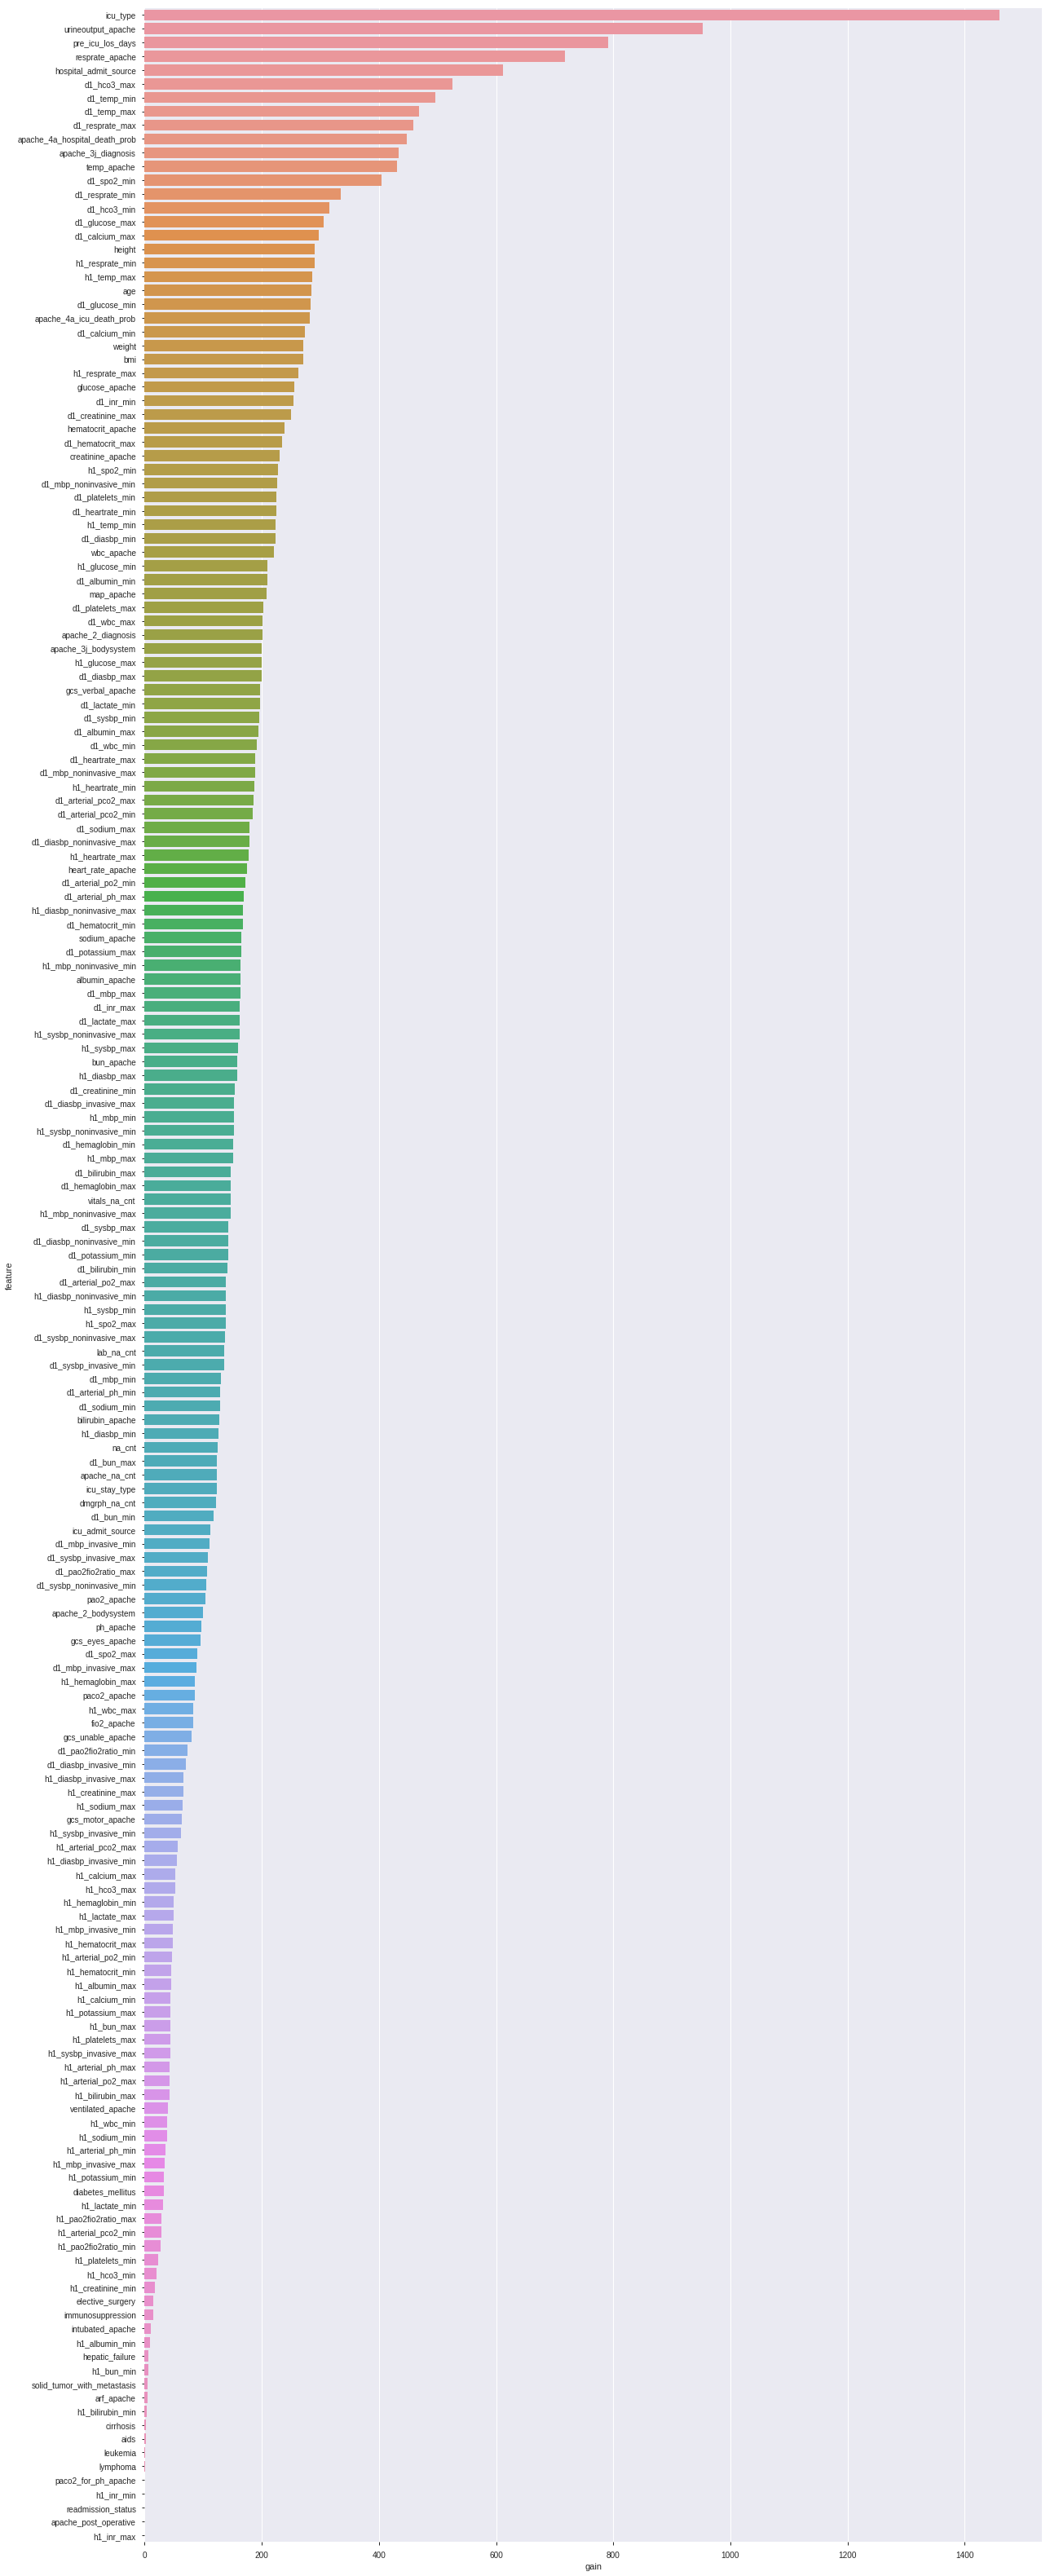

In [27]:
adversarial_features = adversarial_features[['gain', 'feature']].groupby('feature').mean().reset_index()
adversarial_features= adversarial_features.sort_values('gain', ascending=False)
plot_importances(adversarial_features)

In [36]:
adversarial_features2 = adversarial_validation(tr_data, te_data, [ f for f in features if f not in ['icu_id'] ])

Fold 1
Training until validation scores don't improve for 20 rounds
[100]	training's auc: 0.999758	valid_1's auc: 0.999626
Early stopping, best iteration is:
[135]	training's auc: 0.999906	valid_1's auc: 0.999644
Fold 2
Training until validation scores don't improve for 20 rounds
[100]	training's auc: 0.999738	valid_1's auc: 0.999572
Early stopping, best iteration is:
[90]	training's auc: 0.9997	valid_1's auc: 0.999575
Fold 3
Training until validation scores don't improve for 20 rounds
[100]	training's auc: 0.999754	valid_1's auc: 0.999687
Early stopping, best iteration is:
[96]	training's auc: 0.999736	valid_1's auc: 0.999688
Fold 4
Training until validation scores don't improve for 20 rounds
[100]	training's auc: 0.999759	valid_1's auc: 0.999645
[200]	training's auc: 0.999993	valid_1's auc: 0.999676
Early stopping, best iteration is:
[204]	training's auc: 0.999994	valid_1's auc: 0.999677
Fold 5
Training until validation scores don't improve for 20 rounds
[100]	training's auc: 0.99977

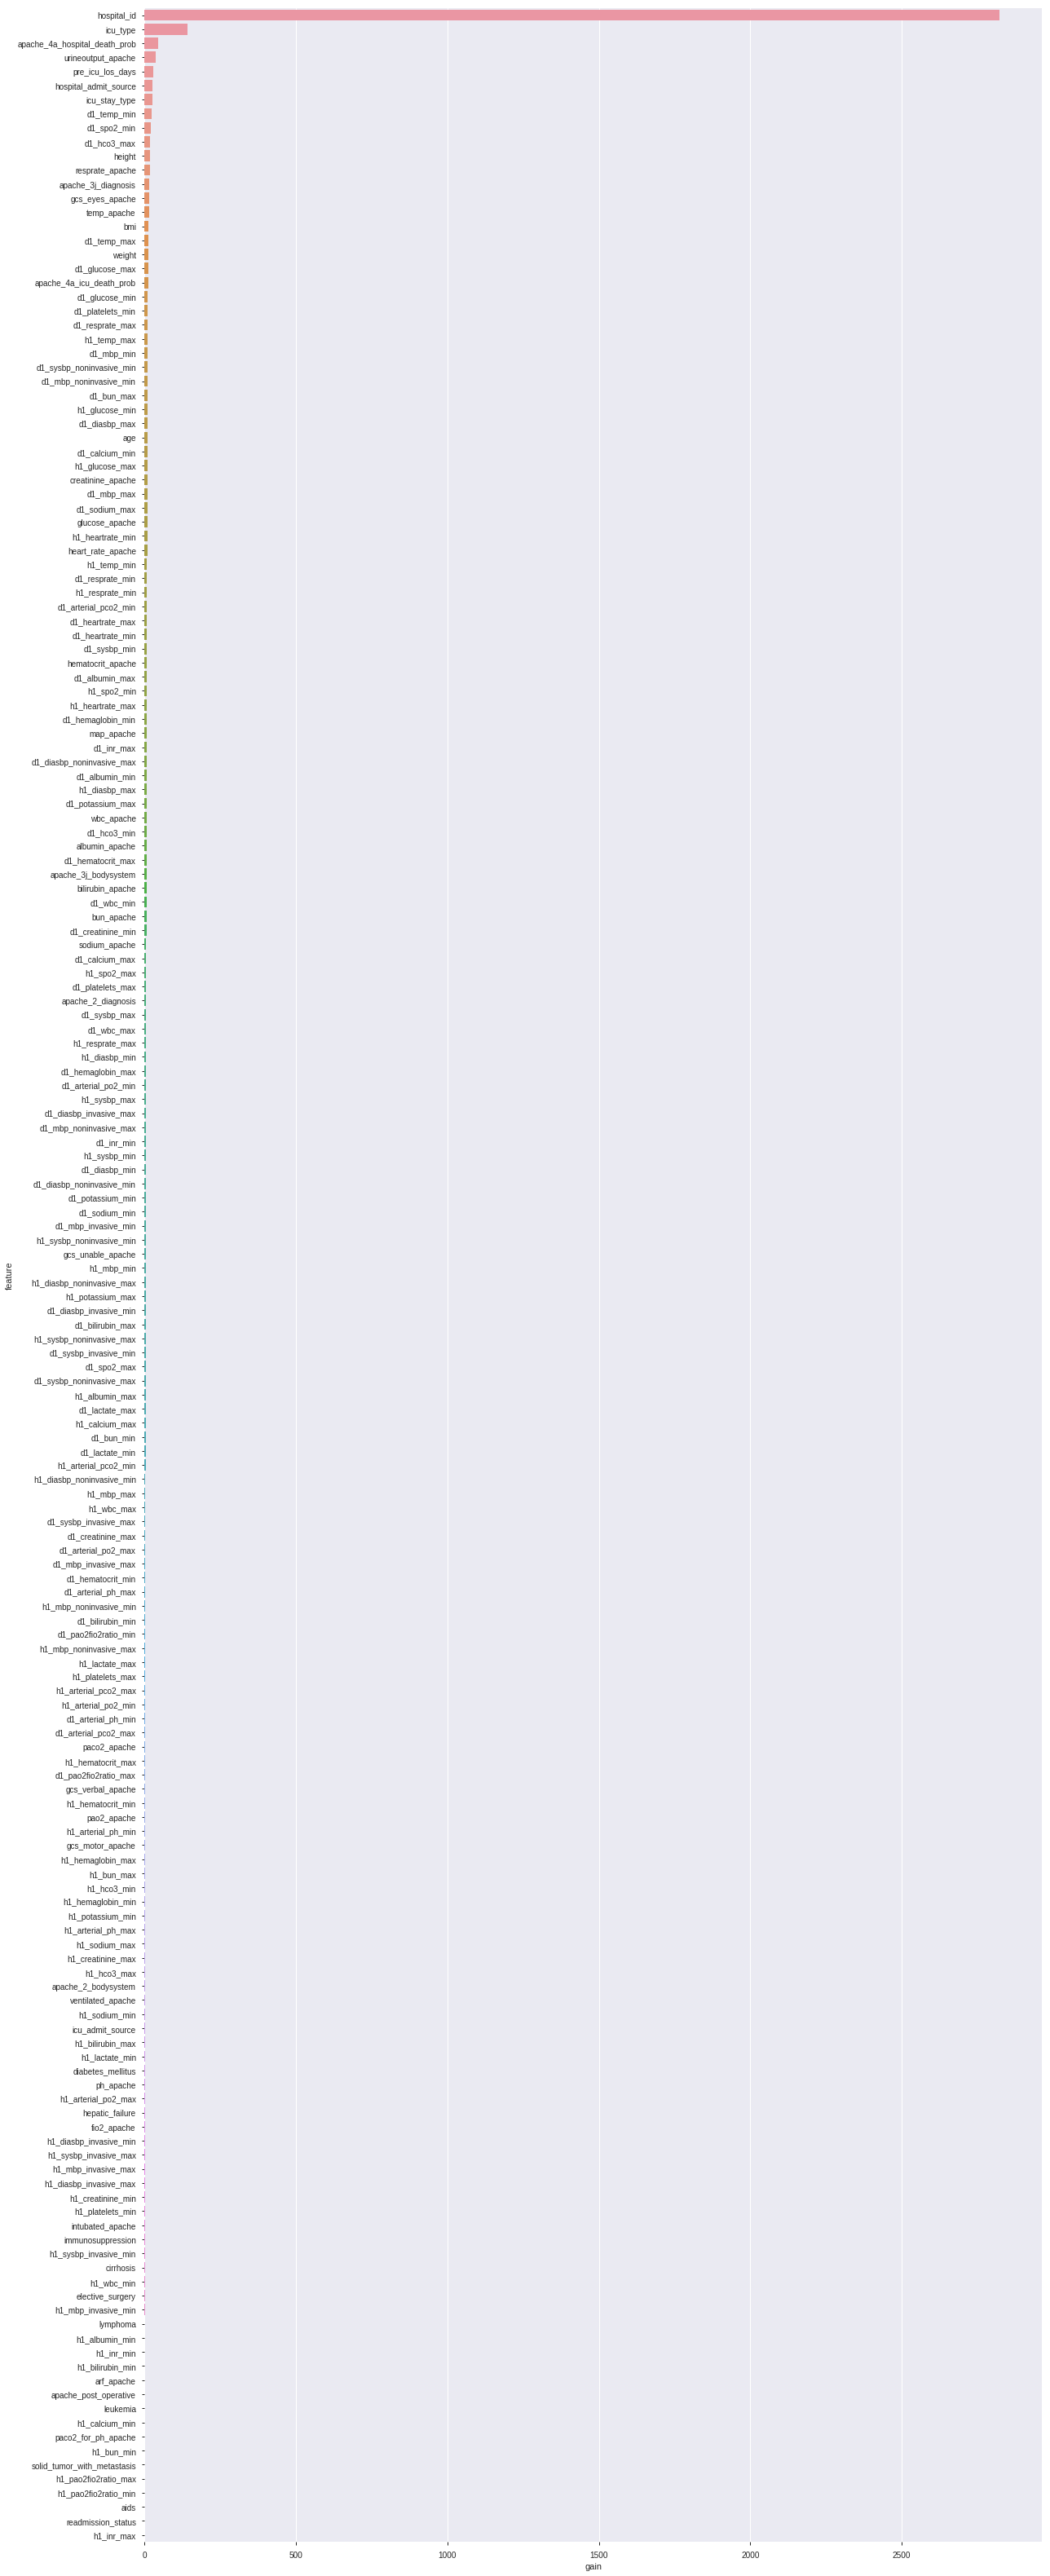

In [37]:
adversarial_features2 = adversarial_features2[['gain', 'feature']].groupby('feature').mean().reset_index()
adversarial_features2= adversarial_features2.sort_values('gain', ascending=False)
plot_importances(adversarial_features2)

In [39]:
adversarial_features3 = adversarial_validation(tr_data, te_data, [ f for f in features if f not in ['icu_id','hospital_id'] ])

Fold 1
Training until validation scores don't improve for 20 rounds
[100]	training's auc: 0.900586	valid_1's auc: 0.882332
[200]	training's auc: 0.929031	valid_1's auc: 0.89558
[300]	training's auc: 0.946881	valid_1's auc: 0.900758
[400]	training's auc: 0.959782	valid_1's auc: 0.903963
[500]	training's auc: 0.969169	valid_1's auc: 0.905806
[600]	training's auc: 0.976205	valid_1's auc: 0.907213
[700]	training's auc: 0.98192	valid_1's auc: 0.908951
Early stopping, best iteration is:
[735]	training's auc: 0.98371	valid_1's auc: 0.909429
Fold 2
Training until validation scores don't improve for 20 rounds
[100]	training's auc: 0.899198	valid_1's auc: 0.877627
[200]	training's auc: 0.928307	valid_1's auc: 0.89204
[300]	training's auc: 0.945776	valid_1's auc: 0.895822
[400]	training's auc: 0.959158	valid_1's auc: 0.899678
[500]	training's auc: 0.968879	valid_1's auc: 0.902212
[600]	training's auc: 0.976165	valid_1's auc: 0.904052
[700]	training's auc: 0.981646	valid_1's auc: 0.905576
[800]	tr

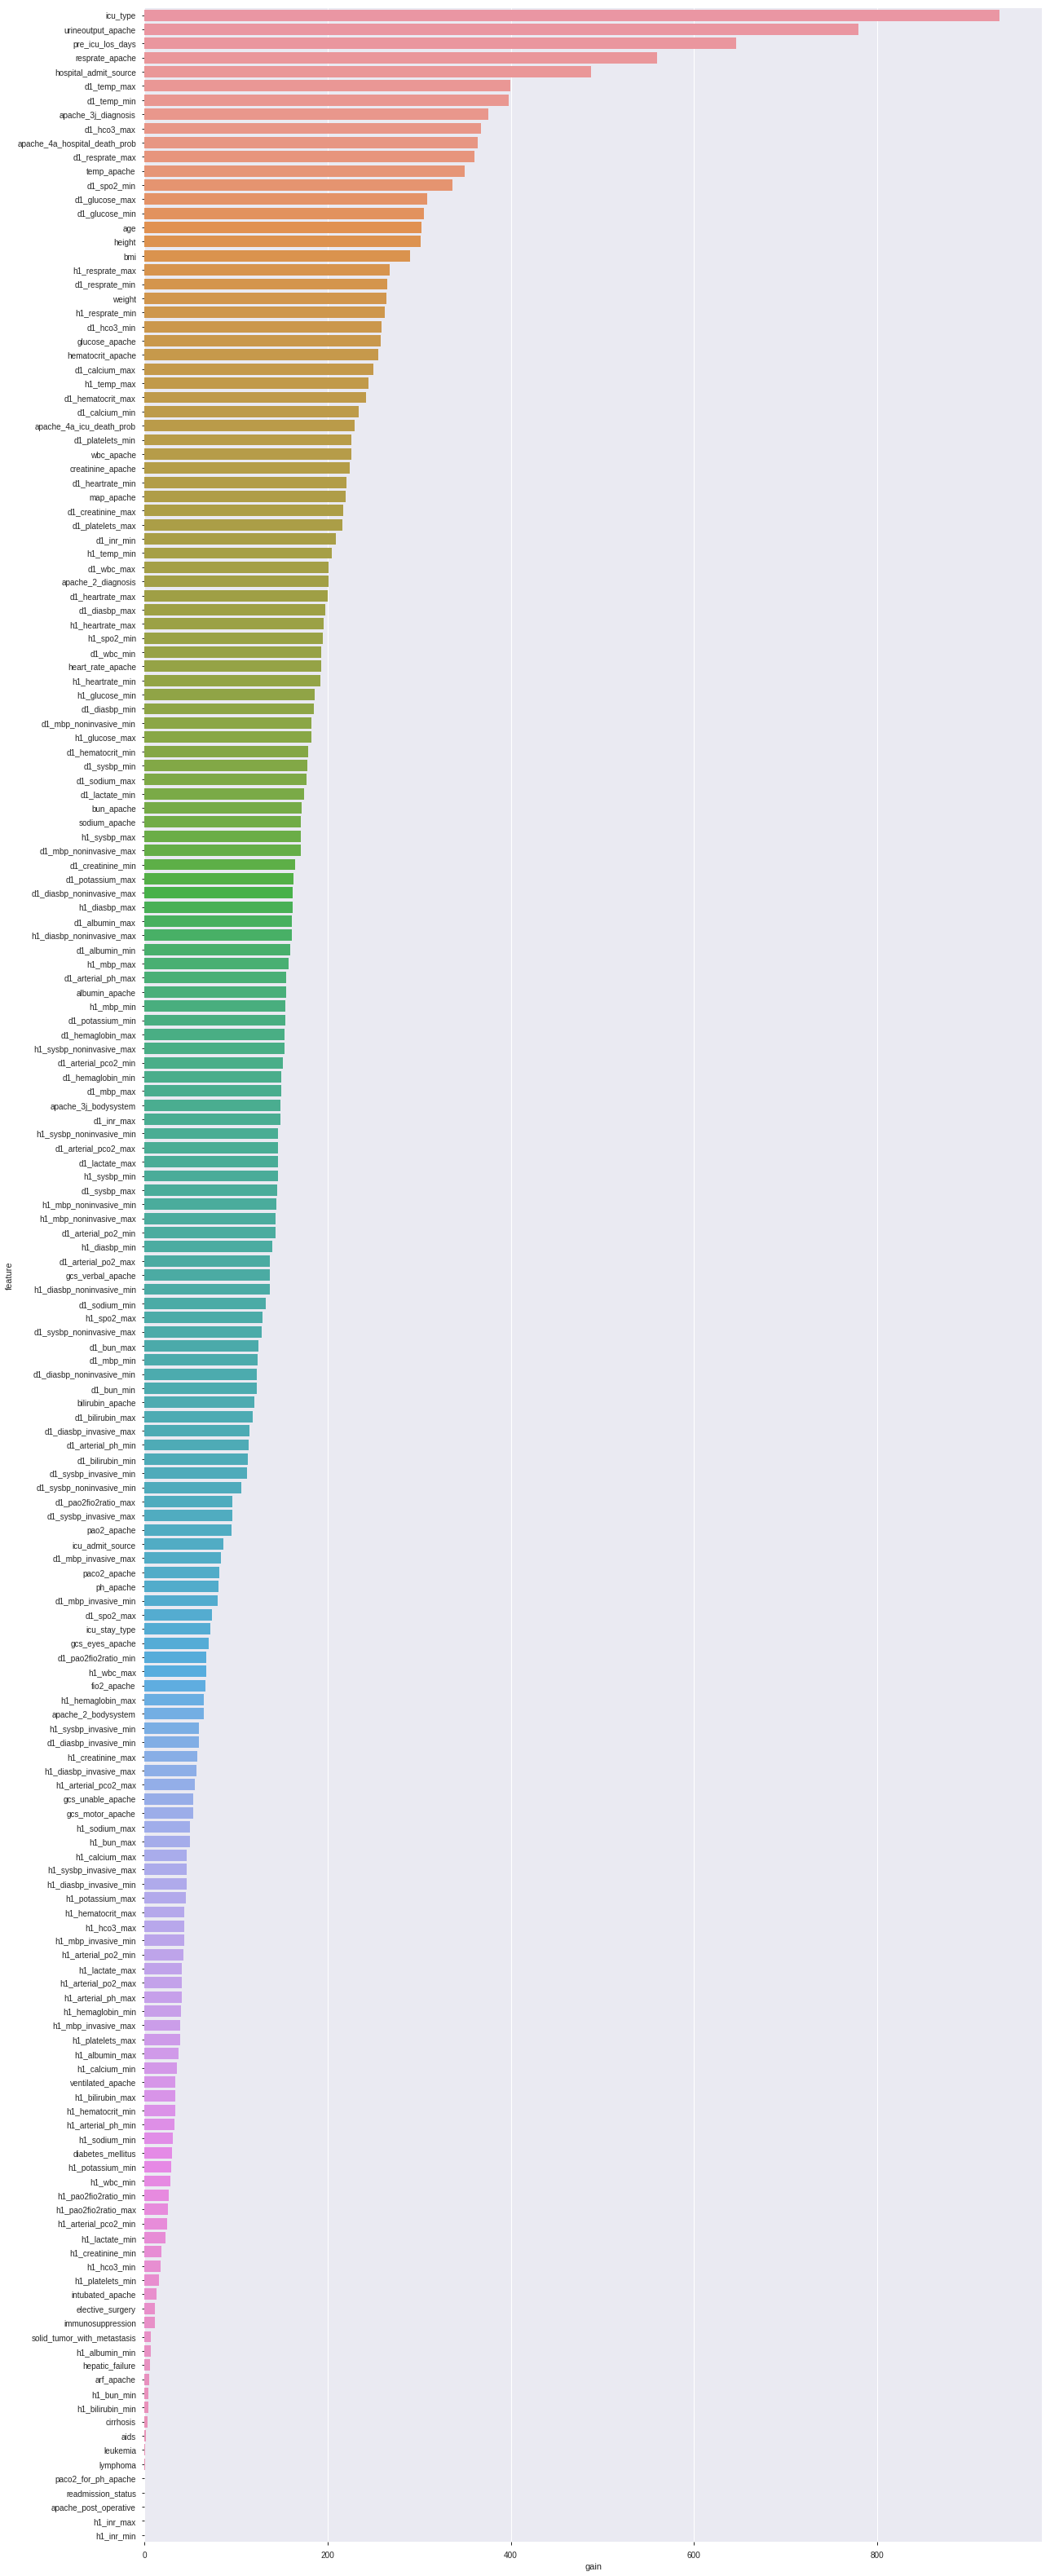

In [41]:
adversarial_features3 = adversarial_features3[['gain', 'feature']].groupby('feature').mean().reset_index()
adversarial_features3= adversarial_features3.sort_values('gain', ascending=False)
plot_importances(adversarial_features3)

In [49]:
pd.DataFrame(LGB_BO.res)

,target,params
0,0.903354,"{'feature_fraction': 0.9517411072096371, 'lamb..."
1,0.904598,"{'feature_fraction': 0.9406909632408085, 'lamb..."
2,0.907388,"{'feature_fraction': 0.5161806097361206, 'lamb..."
3,0.905187,"{'feature_fraction': 0.7633249151033945, 'lamb..."
4,0.905220,"{'feature_fraction': 0.8516961748197043, 'lamb..."
5,0.905858,"{'feature_fraction': 0.6522419586687098, 'lamb..."
6,0.905776,"{'feature_fraction': 0.7905122400330851, 'lamb..."
7,0.907136,"{'feature_fraction': 0.5190130495910859, 'lamb..."
8,0.906303,"{'feature_fraction': 0.6485562210188915, 'lamb..."
9,0.906060,"{'feature_fraction': 0.7109434907341938, 'lamb..."


In [58]:
LGB_BO.max

{'target': 0.9092888477098696,
 'params': {'feature_fraction': 0.5506720563528389,
  'lambda_l1': 0.9636545140570579,
  'lambda_l2': 23.176692603506346,
  'learning_rate': 0.010648705360502449,
  'max_depth': 28.81868455348367,
  'min_child_samples': 12.930127025455153,
  'scale_pos_weight': 1.152217341614635,
  'subsample_freq': 2.0561544591166814}}

In [54]:
reduced_features = [ f for f in features if f not in ['icu_id','hospital_id'] ]
reduced_categoricals_features = [ f for f in categoricals_features if f not in ['icu_id','hospital_id'] ]

In [56]:
if True: # ACTIVATE it if you want to search for better parameter
    lgb_model = Lgb_Model(tr_data,te_data, reduced_features, categoricals=reduced_categoricals_features, ps= LGB_BO.max['params']  )
else :
    lgb_model = Lgb_Model(train,test, reduced_features, categoricals=reduced_categoricals_features, ps=params)

/home/nati/anaconda3/envs/ds/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/nati/anaconda3/envs/ds/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/nati/anaconda3/envs/ds/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.906319	valid_1's auc: 0.892233
[200]	training's auc: 0.919041	valid_1's auc: 0.899725
[300]	training's auc: 0.927919	valid_1's auc: 0.903284
[400]	training's auc: 0.935547	valid_1's auc: 0.904869
[500]	training's auc: 0.942201	valid_1's auc: 0.905911
[600]	training's auc: 0.947856	valid_1's auc: 0.906414
[700]	training's auc: 0.953096	valid_1's auc: 0.906641
[800]	training's auc: 0.957471	valid_1's auc: 0.906843
[900]	training's auc: 0.9616	valid_1's auc: 0.907106
[1000]	training's auc: 0.965298	valid_1's auc: 0.907459
[1100]	training's auc: 0.968577	valid_1's auc: 0.907561
[1200]	training's auc: 0.971667	valid_1's auc: 0.907617
Early stopping, best iteration is:
[1167]	training's auc: 0.970723	valid_1's auc: 0.907749
Partial score of fold 0 is: 0.9077493310190207


/home/nati/anaconda3/envs/ds/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/nati/anaconda3/envs/ds/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/nati/anaconda3/envs/ds/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.906703	valid_1's auc: 0.889217
[200]	training's auc: 0.919428	valid_1's auc: 0.895286
[300]	training's auc: 0.928448	valid_1's auc: 0.897739
[400]	training's auc: 0.936157	valid_1's auc: 0.899312
[500]	training's auc: 0.942751	valid_1's auc: 0.900501
[600]	training's auc: 0.948446	valid_1's auc: 0.901363
[700]	training's auc: 0.953306	valid_1's auc: 0.901769
[800]	training's auc: 0.957719	valid_1's auc: 0.902004
[900]	training's auc: 0.961771	valid_1's auc: 0.902246
[1000]	training's auc: 0.96555	valid_1's auc: 0.902309
[1100]	training's auc: 0.968751	valid_1's auc: 0.902637
[1200]	training's auc: 0.971852	valid_1's auc: 0.902561
Early stopping, best iteration is:
[1108]	training's auc: 0.969037	valid_1's auc: 0.902692
Partial score of fold 1 is: 0.9026923470986716


/home/nati/anaconda3/envs/ds/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/nati/anaconda3/envs/ds/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/nati/anaconda3/envs/ds/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.906404	valid_1's auc: 0.894882
[200]	training's auc: 0.918858	valid_1's auc: 0.901419
[300]	training's auc: 0.927873	valid_1's auc: 0.905231
[400]	training's auc: 0.935396	valid_1's auc: 0.907129
[500]	training's auc: 0.942104	valid_1's auc: 0.908072
[600]	training's auc: 0.947761	valid_1's auc: 0.908504
[700]	training's auc: 0.953041	valid_1's auc: 0.908839
[800]	training's auc: 0.957527	valid_1's auc: 0.909112
[900]	training's auc: 0.96161	valid_1's auc: 0.909321
Early stopping, best iteration is:
[876]	training's auc: 0.960757	valid_1's auc: 0.909398
Partial score of fold 2 is: 0.9093981280586292


/home/nati/anaconda3/envs/ds/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/nati/anaconda3/envs/ds/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/nati/anaconda3/envs/ds/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.907041	valid_1's auc: 0.88568
[200]	training's auc: 0.919304	valid_1's auc: 0.892615
[300]	training's auc: 0.9284	valid_1's auc: 0.896439
[400]	training's auc: 0.936064	valid_1's auc: 0.898477
[500]	training's auc: 0.942666	valid_1's auc: 0.899638
[600]	training's auc: 0.948338	valid_1's auc: 0.900357
[700]	training's auc: 0.953432	valid_1's auc: 0.900546
[800]	training's auc: 0.957914	valid_1's auc: 0.900683
[900]	training's auc: 0.961954	valid_1's auc: 0.900789
[1000]	training's auc: 0.965763	valid_1's auc: 0.900914
[1100]	training's auc: 0.969001	valid_1's auc: 0.9009
[1200]	training's auc: 0.97189	valid_1's auc: 0.901028
Early stopping, best iteration is:
[1167]	training's auc: 0.97098	valid_1's auc: 0.901091
Partial score of fold 3 is: 0.9010911839338139


/home/nati/anaconda3/envs/ds/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/nati/anaconda3/envs/ds/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/nati/anaconda3/envs/ds/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.906377	valid_1's auc: 0.888134
[200]	training's auc: 0.919247	valid_1's auc: 0.894986
[300]	training's auc: 0.928218	valid_1's auc: 0.898371
[400]	training's auc: 0.935803	valid_1's auc: 0.900594
[500]	training's auc: 0.942554	valid_1's auc: 0.901721
[600]	training's auc: 0.9483	valid_1's auc: 0.902695
[700]	training's auc: 0.953252	valid_1's auc: 0.903231
[800]	training's auc: 0.957789	valid_1's auc: 0.903708
[900]	training's auc: 0.961739	valid_1's auc: 0.90377
[1000]	training's auc: 0.965568	valid_1's auc: 0.903748
Early stopping, best iteration is:
[928]	training's auc: 0.962886	valid_1's auc: 0.903924
Partial score of fold 4 is: 0.9039243699253836


/home/nati/anaconda3/envs/ds/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/nati/anaconda3/envs/ds/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/nati/anaconda3/envs/ds/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.906884	valid_1's auc: 0.888971
[200]	training's auc: 0.919239	valid_1's auc: 0.895409
[300]	training's auc: 0.928066	valid_1's auc: 0.898504
[400]	training's auc: 0.935698	valid_1's auc: 0.900568
[500]	training's auc: 0.942371	valid_1's auc: 0.901425
[600]	training's auc: 0.948105	valid_1's auc: 0.902047
[700]	training's auc: 0.953227	valid_1's auc: 0.902618
[800]	training's auc: 0.957802	valid_1's auc: 0.902946
[900]	training's auc: 0.961803	valid_1's auc: 0.902964
[1000]	training's auc: 0.965588	valid_1's auc: 0.903163
[1100]	training's auc: 0.968735	valid_1's auc: 0.903369
[1200]	training's auc: 0.971648	valid_1's auc: 0.903568
[1300]	training's auc: 0.97446	valid_1's auc: 0.903646
Early stopping, best iteration is:
[1295]	training's auc: 0.974338	valid_1's auc: 0.903699
Partial score of fold 5 is: 0.9036991331476725


/home/nati/anaconda3/envs/ds/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/nati/anaconda3/envs/ds/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/nati/anaconda3/envs/ds/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.905281	valid_1's auc: 0.894599
[200]	training's auc: 0.918105	valid_1's auc: 0.903406
[300]	training's auc: 0.927159	valid_1's auc: 0.907295
[400]	training's auc: 0.934787	valid_1's auc: 0.909615
[500]	training's auc: 0.94166	valid_1's auc: 0.910996
[600]	training's auc: 0.947464	valid_1's auc: 0.911658
[700]	training's auc: 0.952502	valid_1's auc: 0.912446
[800]	training's auc: 0.957123	valid_1's auc: 0.912813
[900]	training's auc: 0.961169	valid_1's auc: 0.912872
[1000]	training's auc: 0.964889	valid_1's auc: 0.913249
[1100]	training's auc: 0.968169	valid_1's auc: 0.913093
[1200]	training's auc: 0.971461	valid_1's auc: 0.91342
[1300]	training's auc: 0.974133	valid_1's auc: 0.913375
Early stopping, best iteration is:
[1226]	training's auc: 0.972201	valid_1's auc: 0.913451
Partial score of fold 6 is: 0.9134511463993796


/home/nati/anaconda3/envs/ds/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/nati/anaconda3/envs/ds/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/nati/anaconda3/envs/ds/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.905974	valid_1's auc: 0.896863
[200]	training's auc: 0.918622	valid_1's auc: 0.904849
[300]	training's auc: 0.927572	valid_1's auc: 0.90781
[400]	training's auc: 0.93543	valid_1's auc: 0.909512
[500]	training's auc: 0.942122	valid_1's auc: 0.910869
[600]	training's auc: 0.947855	valid_1's auc: 0.911552
[700]	training's auc: 0.953068	valid_1's auc: 0.912177
[800]	training's auc: 0.957706	valid_1's auc: 0.91258
[900]	training's auc: 0.961871	valid_1's auc: 0.912661
[1000]	training's auc: 0.965529	valid_1's auc: 0.912817
[1100]	training's auc: 0.968788	valid_1's auc: 0.912885
[1200]	training's auc: 0.971812	valid_1's auc: 0.913248
[1300]	training's auc: 0.974689	valid_1's auc: 0.913131
Early stopping, best iteration is:
[1234]	training's auc: 0.972791	valid_1's auc: 0.913301
Partial score of fold 7 is: 0.9133011896967376


/home/nati/anaconda3/envs/ds/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/nati/anaconda3/envs/ds/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/nati/anaconda3/envs/ds/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.906361	valid_1's auc: 0.891715
[200]	training's auc: 0.918868	valid_1's auc: 0.899321
[300]	training's auc: 0.927889	valid_1's auc: 0.90336
[400]	training's auc: 0.935419	valid_1's auc: 0.905199
[500]	training's auc: 0.9421	valid_1's auc: 0.906324
[600]	training's auc: 0.948112	valid_1's auc: 0.907355
[700]	training's auc: 0.95324	valid_1's auc: 0.907817
[800]	training's auc: 0.957672	valid_1's auc: 0.907937
Early stopping, best iteration is:
[739]	training's auc: 0.955113	valid_1's auc: 0.907958
Partial score of fold 8 is: 0.9079580263790792


/home/nati/anaconda3/envs/ds/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/nati/anaconda3/envs/ds/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/nati/anaconda3/envs/ds/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.905894	valid_1's auc: 0.894396
[200]	training's auc: 0.918238	valid_1's auc: 0.903025
[300]	training's auc: 0.92733	valid_1's auc: 0.907055
[400]	training's auc: 0.935114	valid_1's auc: 0.909741
[500]	training's auc: 0.941721	valid_1's auc: 0.911284
[600]	training's auc: 0.947707	valid_1's auc: 0.912368
[700]	training's auc: 0.952821	valid_1's auc: 0.913085
[800]	training's auc: 0.957311	valid_1's auc: 0.913717
[900]	training's auc: 0.961332	valid_1's auc: 0.913821
[1000]	training's auc: 0.965134	valid_1's auc: 0.914283
[1100]	training's auc: 0.968493	valid_1's auc: 0.914316
Early stopping, best iteration is:
[1016]	training's auc: 0.96572	valid_1's auc: 0.914364
Partial score of fold 9 is: 0.9143636809676909
[0.166166   0.71212165 0.00133422 ... 0.0249665  0.17892895 0.12584345] [0 0 0 ... 0 0 0]
Our oof AUC score is:  0.9077204459293162


In [57]:
te_data["hospital_death"] = lgb_model.y_pred
te_data[["encounter_id","hospital_death"]].to_csv("submission2.csv",index=False)

In [87]:
model_dict

{'oof_preds': array([0.166166  , 0.71212165, 0.00133422, ..., 0.0249665 , 0.17892895,
        0.12584345]),
 'test_pred': array([0.02368   , 0.02888837, 0.03026846, ..., 0.12523436, 0.01513861,
        0.22064482]),
 'features': ['age',
  'bmi',
  'elective_surgery',
  'height',
  'hospital_admit_source',
  'icu_admit_source',
  'icu_stay_type',
  'icu_type',
  'pre_icu_los_days',
  'readmission_status',
  'weight',
  'albumin_apache',
  'apache_2_diagnosis',
  'apache_3j_diagnosis',
  'apache_post_operative',
  'arf_apache',
  'bilirubin_apache',
  'bun_apache',
  'creatinine_apache',
  'fio2_apache',
  'gcs_eyes_apache',
  'gcs_motor_apache',
  'gcs_unable_apache',
  'gcs_verbal_apache',
  'glucose_apache',
  'heart_rate_apache',
  'hematocrit_apache',
  'intubated_apache',
  'map_apache',
  'paco2_apache',
  'paco2_for_ph_apache',
  'pao2_apache',
  'ph_apache',
  'resprate_apache',
  'sodium_apache',
  'temp_apache',
  'urineoutput_apache',
  'ventilated_apache',
  'wbc_apache',
  

In [78]:
#some new things I want to check after this initial run...

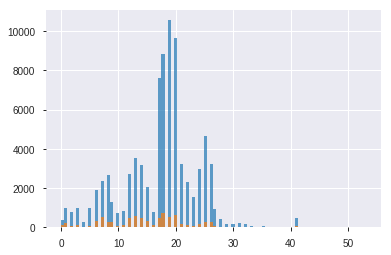

In [73]:
temp = pd.concat([tr_data.loc[:,[x for x in tr_data.columns if (('invasive' in x) | ('apache' in x))]].isnull().sum(axis=1),tr_data['hospital_death']],axis=1)
temp.columns=['num_nas','hospital_death']
temp.loc[temp.hospital_death==0,'num_nas'].hist(alpha=0.7,bins=100)
temp.loc[temp.hospital_death==1,'num_nas'].hist(alpha=0.7,bins=100)

In [77]:
pd.concat([temp.loc[temp.hospital_death==1,'num_nas'].value_counts()/temp.loc[temp.hospital_death==1,'num_nas'].shape[0],
           temp.loc[temp.hospital_death==0,'num_nas'].value_counts()/temp.loc[temp.hospital_death==0,'num_nas'].shape[0]],axis=1)

,num_nas,num_nas
0,0.012761,0.004248
1,0.030449,0.011695
2,0.011371,0.009487
3,0.015919,0.011969
4,0.002780,0.003162
5,0.010107,0.012005
6,0.040430,0.022507
7,0.067593,0.028079
8,0.032849,0.032017
9,0.030954,0.015167


In [95]:
BO_search_space = pd.DataFrame(LGB_BO.space.params)
BO_search_space.columns=LGB_BO.space.keys
BO_search_space['target'] = LGB_BO.space.target
BO_search_space.to_csv('BO_search_space_all_features_v0.csv')

In [48]:
sub1 = pd.read_csv('./submission1_bayes_opt_all_features.csv')
sub2 = pd.read_csv('./submission2_bayes_opt_advrs_val_features.csv')
sub3 = pd.read_csv('./submission3_simple_10fold_with_na_cnt_featrs.csv')

In [52]:
subs = pd.concat([sub1,sub2,sub3],axis=1)

In [53]:
subs = subs.iloc[:,[0,1,3,5]]
subs.set_index('encounter_id',inplace=True)

In [56]:
subs['median'] = np.median(subs,axis=1)
subs['mean'] = np.mean(subs,axis=1)
subs['std'] = np.std(subs,axis=1)

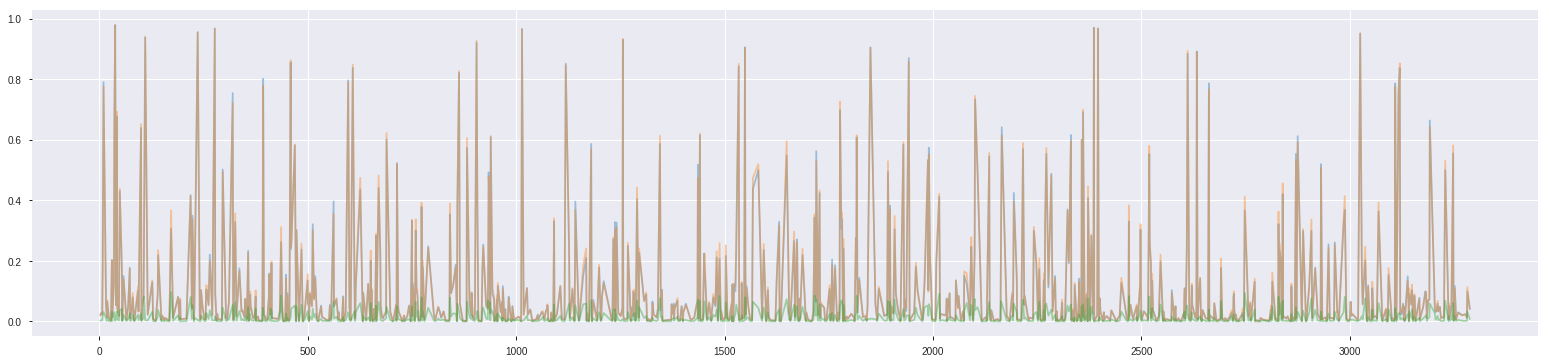

In [62]:
plt.figure(figsize=(27,6))
plt.plot(subs.iloc[:1000,-3:],alpha=0.4)

In [72]:
sub4 = sub2.copy()
sub4['hospital_death'] = sub1.hospital_death*0.08+sub2.hospital_death*0.89+sub3.hospital_death*0.03

In [73]:
sub4.columns = ['encounter_id','hospital_death']
sub4.to_csv('submission4_weighted_avg_prev_3.csv',index=False)

In [71]:
sub4

0        0.022855
1        0.028298
2        0.029143
3        0.179186
4        0.797388
           ...   
39303    0.002118
39304    0.040455
39305    0.129972
39306    0.014516
39307    0.212684
Name: hospital_death, Length: 39308, dtype: float64